**Author :** Rutendo F. Sigauke

**Input  :** 

1. Summary of normalized counts        

        - gene_bidir_tpm_summary_allBidirs_filteredSamples.tsv.gz

2. Bidirectional and gene pairs (significant based on default settings)
        
3. Metadata for high QC samples

        - human_samples_QC_GC_protocol_filtered.tsv.gz

**Output :**

1. Further filtered significant pairs

        - sig_inter_nobs_dist_filtered.txt.gz

2. Figures (summary of pairs)

# Summary

Here transcription levels of **Intergenic** bidirectional transcracripts are correlated with genes. See https://github.com/Dowell-Lab/bidir_gene_pairs for the code.


- There are 1440890 gene and bidirectional pairs

- Percent of genes linked to bidirectional = 82.7373740870227 (23,902)

- Percent of bidirectionals linked to genes = 21.1507443473377 (179,257)

Most pairs are found in only one tissue.

# Load libraries

In [1]:
library(data.table) ## load files into R faster
library(ggplot2) ##plotting package
library(dplyr)   ## data structure wrangling
library(cowplot) ##plots + arrange plots etc
library(UpSetR) #upset plot


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

## Filter on nObs and TES distance

In [2]:
removing_DoPAD_bidirs <- function(pairs, dist_DoPAD=15000, number_observed=10) {
    #' Remove pairs where the bidirectionals transcript is Downstream of Polyadenylation Site (DoPAD)
    #1. Subset by distance from TES
    pairs_dopad <- subset(pairs, abs(distance_tes) < dist_DoPAD)
    
    #2. Label bidirectionals that fall closer to the TES than to the TSS
    pairs_dopad$filter <- ifelse(abs(pairs_dopad$distance_tss) < abs(pairs_dopad$distance_tes),
                                        FALSE, TRUE)
    
    pairs_dopad_removing <- pairs_dopad[pairs_dopad$filter=='TRUE',]

    #This removes any pairs with bidirectionals in DoPAD as opposed to only removing the pair
    pairs_keeping <- pairs[!pairs$transcript_2 %in% pairs_dopad_removing$transcript_2,]
    
    pairs_keeping_nObs <- subset(pairs_keeping, nObs > number_observed)
    return(pairs_keeping_nObs)
}

## Bidirectionals paired to a gene by tissue

In [3]:
gene_bidirs_by_tissue <- function(sig_pairs, metadata, gene_id){

    gene_pairs <- sig_pairs[grepl(gene_id,sig_pairs$transcript_1),]
    
    gene_pairs$tissues <- factor(gene_pairs$tissue,
                            levels=sort(unique(metadata$tissue)))

    #for each gene, get tissue
    gene_tissues <- unique(gene_pairs$tissue)

    #for each tissue assign bidirectionals per gene
    gene_bidirs_tissue_list <- list()
    for (i in 1: length(gene_tissues)){

        tissue_name <- gene_tissues[[i]]
        gene_bidirs_tissue_list[[tissue_name]] <- subset(gene_pairs, 
                                                         tissue == tissue_name)$transcript_2

    }
    
    return(gene_bidirs_tissue_list)
}

## Assign promoter bidirectionals to gene

In [4]:
assign_promoter_bidirs <- function(pairs, promoter_dist=1000) {
    #' Assign promoter bidirectionals to only 1 gene.
    
    #1. Assign promoter label if within promoter_dist
    pairs$promoter <- ifelse(abs(pairs$distance_tss) < promoter_dist, 
                             'promoter', 
                             'candidate_enhancer')
    
    #2. Get all the promoters
    pairs_promoters <- subset(pairs, promoter=='promoter')
    
    #3. Get promoter bidirectionals
    promoter_bidir <- unique(pairs_promoters$transcript_2)
    
    #4. Filter these pairs out from the pairs data.table
    pairs_no_promoters <- pairs[!pairs$transcript_2 %in% promoter_bidir,]

    #5. Final links with promoters assigned to close genes
    pairs_promoters_labels <- rbind(pairs_promoters, 
                                    pairs_no_promoters)

    #6. Sort the table by transcript1_chrom and transcript1_start
    pairs_promoters_labels_order <- pairs_promoters_labels[order(rank(transcript1_chrom),
                                                                                  transcript1_start)]
    
    return(pairs_promoters_labels_order)
    
}

# Load data

## Transcription summary

In [5]:
gene_bidir_tpm_summary_allBidirs_filteredSamples <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/gene_bidir_tpm_summary_allBidirs_filteredSamples.tsv.gz')
head(gene_bidir_tpm_summary_allBidirs_filteredSamples)

chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.072099287,5.198307e-03,6.76054154,9.002053e-03,0.0000000,8.0092052,1.25232307,0,29,3.8615180,genes
chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.190457404,3.627402e-02,163.61697071,2.178655e-01,0.1674576,0.8741973,1.58704620,0,749,99.7336884,genes
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.000000000,0.000000e+00,0.00000000,0.000000e+00,0.0000000,NA,0.00000000,0,0,0.0000000,genes
chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,139,0.034063044,1.160291e-03,0.93347658,1.242978e-03,0.0000000,27.4043792,0.93347658,0,1,0.1331558,genes
chr1,34610,35591,FAM138A:NR_026818.1,.,-,982,0.002709721,7.342586e-06,0.07425821,9.887911e-05,0.0000000,27.4043792,0.07425821,0,1,0.1331558,genes
chr1,66168,71585,OR4F5:NM_001005484.2,.,+,5418,0.002555593,6.531054e-06,0.18860450,2.511378e-04,0.0000000,10.1760572,0.04010044,0,11,1.4647137,genes


In [6]:
gene_bidir_tpm_summary_allBidirs_filteredSamples$gene_id <- as.character(lapply(strsplit(gene_bidir_tpm_summary_allBidirs_filteredSamples$gene_transcript, ':'),
                                                      `[`, 1))
head(gene_bidir_tpm_summary_allBidirs_filteredSamples)

chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.072099287,5.198307e-03,6.76054154,9.002053e-03,0.0000000,8.0092052,1.25232307,0,29,3.8615180,genes,DDX11L1
chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.190457404,3.627402e-02,163.61697071,2.178655e-01,0.1674576,0.8741973,1.58704620,0,749,99.7336884,genes,WASH7P
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.000000000,0.000000e+00,0.00000000,0.000000e+00,0.0000000,NA,0.00000000,0,0,0.0000000,genes,MIR6859-1
chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,139,0.034063044,1.160291e-03,0.93347658,1.242978e-03,0.0000000,27.4043792,0.93347658,0,1,0.1331558,genes,MIR1302-2
chr1,34610,35591,FAM138A:NR_026818.1,.,-,982,0.002709721,7.342586e-06,0.07425821,9.887911e-05,0.0000000,27.4043792,0.07425821,0,1,0.1331558,genes,FAM138A
chr1,66168,71585,OR4F5:NM_001005484.2,.,+,5418,0.002555593,6.531054e-06,0.18860450,2.511378e-04,0.0000000,10.1760572,0.04010044,0,11,1.4647137,genes,OR4F5


## Gene bidirectional pairs


In [7]:
sig_corr_inter_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/correlations/inter/significant'


In [8]:
##get paths for the tables
sig_corr_inter_files <- list.files(path=sig_corr_inter_path, 
                              pattern="*.gz$",full.names=TRUE)
length(sig_corr_inter_files)


[1] 24

In [9]:
##load all correlation files 
sig_corr_inter_DT_list <- lapply(sig_corr_inter_files, 
                                 data.table::fread) 

##merge the files to a single data.table
sig_corr_DT_inter <- do.call(rbind, 
                             sig_corr_inter_DT_list)

dim(sig_corr_DT_inter)
head(sig_corr_DT_inter)

[1] 3663224      22

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pcc,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,-0.6346208,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,0.8022481,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,0.7175133,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33300941,33302057,chr1:33300941-33302057,⋯,0.6277804,5.622064e-24,3.568232e-21,206,11.519280,19599,5266,downstream,blood,92.792793
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33302057,33302621,chr1:33302057-33302621,⋯,0.6714745,1.414612e-27,1.377176e-24,200,12.750515,18759,4426,downstream,blood,90.090090
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33303287,33304263,chr1:33303287-33304263,⋯,0.7159887,1.088462e-30,1.471197e-27,187,13.949768,17323,2990,downstream,blood,84.234234


In [10]:
##filter pairs by downstream transcripts and number of samples supporting an interactions
sig_inter_nobs_dist_filtered <- removing_DoPAD_bidirs(sig_corr_DT_inter)
sig_inter_nobs_dist_filtered$tissue <- gsub(" ", "_", sig_inter_nobs_dist_filtered$tissue)
head(sig_inter_nobs_dist_filtered)

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pcc,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,-0.6346208,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,0.8022481,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,0.7175133,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93910534,93911046,chr1:93910534-93911046,⋯,0.6801779,5.905776e-13,6.731068e-11,86,8.504139,210358,82043,downstream,blood,38.738739
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93931066,93931248,chr1:93931066-93931248,⋯,0.6868776,5.196389e-06,1.088703e-04,35,5.429220,189991,61676,downstream,blood,15.765766
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93946840,93947120,chr1:93946840-93947120,⋯,0.7282994,2.185860e-07,6.991417e-06,38,6.376853,174168,45853,downstream,blood,17.117117


In [11]:
data.table::fwrite(sig_inter_nobs_dist_filtered,
                  "/scratch/Shares/dowell/rutendo/projects/DBNascent_Analysis/data/gene_bidir_significant_pairs/sig_inter_nobs_dist_filtered.txt.gz",
                  sep="\t")

In [12]:
sig_inter_nobs_dist_filtered$pair_id <- paste0(sig_inter_nobs_dist_filtered$transcript_1,'~',
                                              sig_inter_nobs_dist_filtered$transcript_2)
nrow(sig_inter_nobs_dist_filtered)
head(sig_inter_nobs_dist_filtered, 3)

[1] 1440890

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847,A3GALT2:NM_001080438.1~chr1:33036652-33037238
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207,A3GALT2:NM_001080438.1~chr1:33224694-33224966
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910,A3GALT2:NM_001080438.1~chr1:33242850-33243170


In [13]:
sig_inter_nobs_dist_filtered_promoters <- assign_promoter_bidirs(sig_inter_nobs_dist_filtered)
nrow(sig_inter_nobs_dist_filtered_promoters)
head(sig_inter_nobs_dist_filtered_promoters, 3)

[1] 1275143

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,promoter
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,780349,780857,chr1:780349-780857,⋯,0.0055513870,18,4.729244,768730,766194,downstream,uterus,31.03448,DDX11L1:NR_046018.2~chr1:780349-780857,candidate_enhancer
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,788419,788857,chr1:788419-788857,⋯,0.0003047326,18,6.706793,776765,774229,downstream,uterus,31.03448,DDX11L1:NR_046018.2~chr1:788419-788857,candidate_enhancer
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,790950,791210,chr1:790950-791210,⋯,0.0084514316,15,4.717384,779207,776671,downstream,uterus,25.86207,DDX11L1:NR_046018.2~chr1:790950-791210,candidate_enhancer


## Metadata

In [14]:
##metadata
metadata_celltype <- data.table::fread('/scratch/Shares/dowell/rutendo/projects/DBNascent_Analysis/data/metadata/human_samples_QC_GC_protocol_filtered.tsv.gz')
dim(metadata_celltype)
head(metadata_celltype)

[1] 751  14

organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_name,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266931,cell line,MV4-11,1,2,1,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266932,cell line,MV4-11,2,1,2,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266933,cell line,MV4-11,1,2,1,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266934,cell line,MV4-11,1,2,2,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266935,cell line,MV4-11,1,2,1,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266936,cell line,MV4-11,1,2,2,experimental


# Summary of pairs

## Position of bidirectional relative to TSS

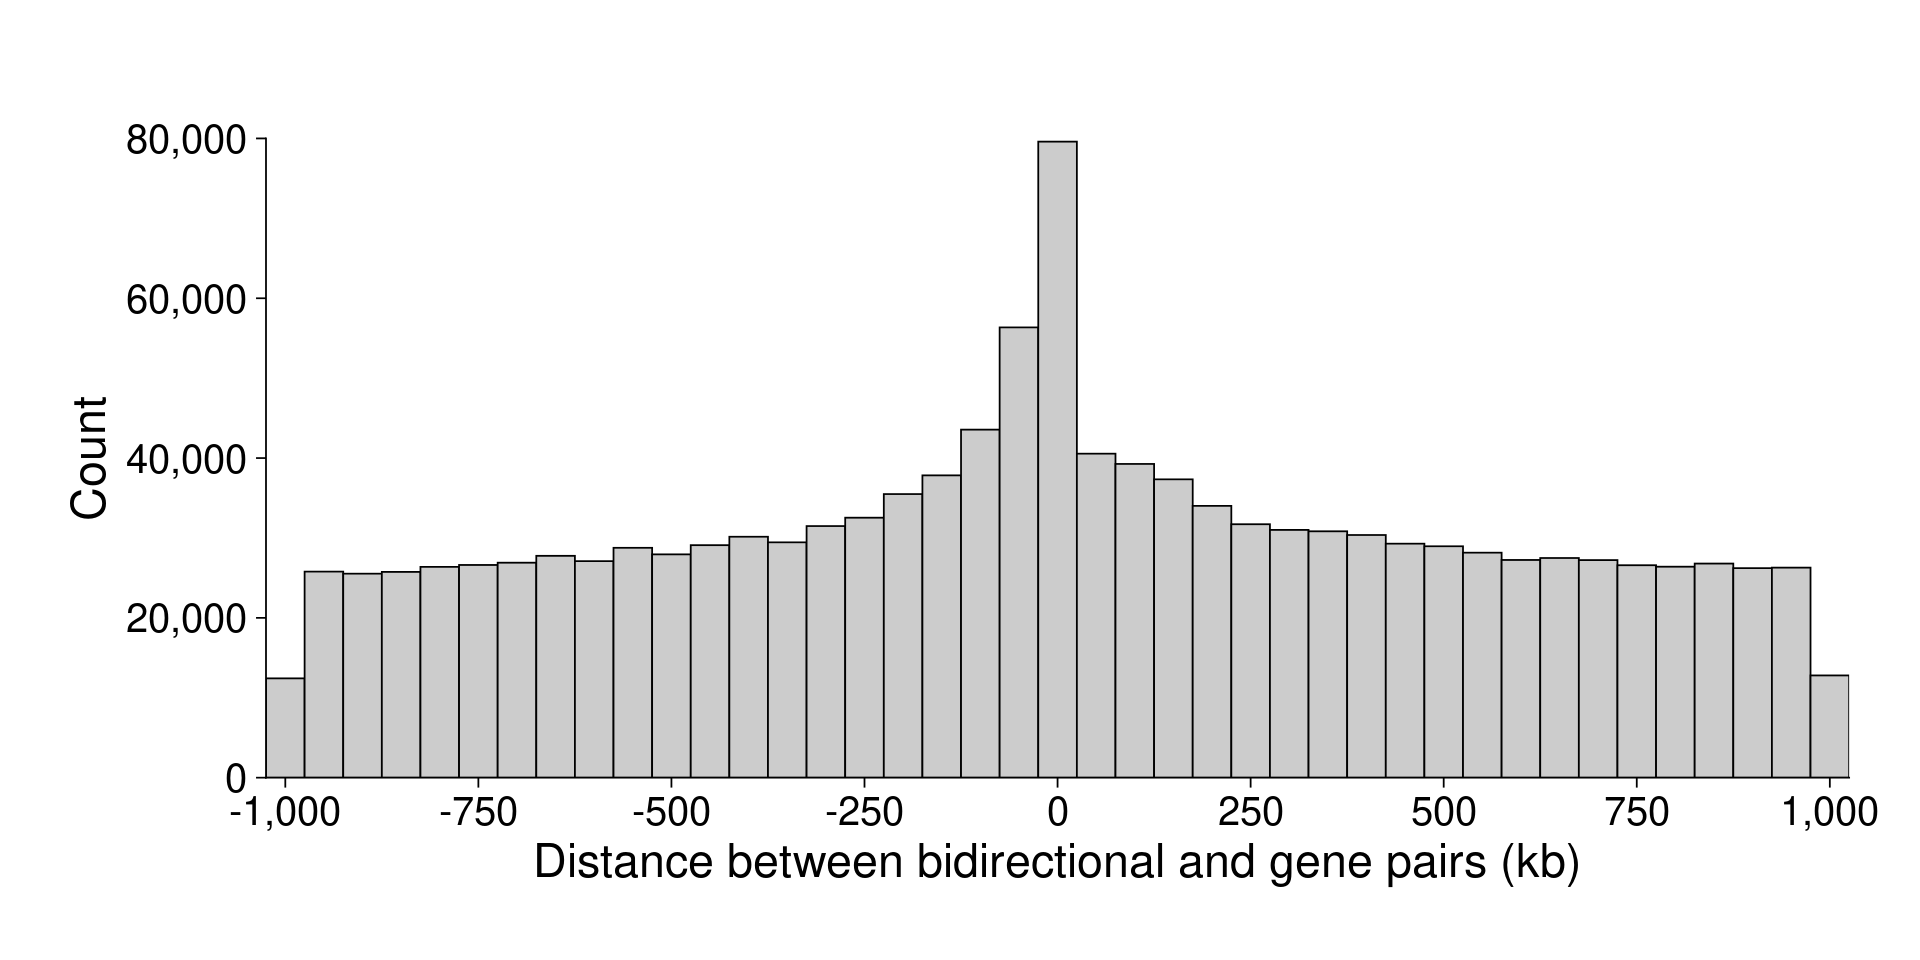

In [15]:
options(repr.plot.width=16, repr.plot.height=8)

gene_bidir_dist_hist <- ggplot(sig_inter_nobs_dist_filtered_promoters,
                               aes(x=(distance_tss)/1000)) +
  geom_histogram(color="black", fill="gray80", binwidth=50) +
labs(title = " ", 
       y = "Count",
       x = "Distance between bidirectional and gene pairs (kb)") +
theme_cowplot(24) +
scale_x_continuous(expand = c(0, 0),
                   breaks=seq(-1000,1000,250),
                  labels = scales::comma) +
scale_y_continuous(expand = c(0, 0),
                   limits=c(0,80000),
                  labels = scales::comma) +
theme(plot.title = element_text(size = 30, hjust = 0.5),
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) +
 theme(plot.margin = margin(1.5,1.5,1.5,1.5, "cm"))

gene_bidir_dist_hist

In [16]:
ggsave(gene_bidir_dist_hist, width = 16, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/gene_bidir_dist_hist.pdf',
      bg = "transparent")

ggsave(gene_bidir_dist_hist, width = 16, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/gene_bidir_dist_hist.png',
      bg = "transparent")

## Number of pairs per chromosome

In [17]:
#assign a pair id with gene-bidirectionals
#sig_inter_nobs_dist_filtered$pair_id <- paste0(sig_inter_nobs_dist_filtered$transcript_1, "~",sig_inter_nobs_dist_filtered$transcript_2)
sig_inter_nobs_dist_filtered_unique <- unique(sig_inter_nobs_dist_filtered_promoters[,c('transcript1_chrom', 'pair_id',
                                                                              'transcript_1', 
                                                                             'transcript_2')])
nrow(sig_inter_nobs_dist_filtered_unique)
head(sig_inter_nobs_dist_filtered_unique, 3)

[1] 985218

transcript1_chrom,pair_id,transcript_1,transcript_2
<chr>,<chr>,<chr>,<chr>
chr1,DDX11L1:NR_046018.2~chr1:780349-780857,DDX11L1:NR_046018.2,chr1:780349-780857
chr1,DDX11L1:NR_046018.2~chr1:788419-788857,DDX11L1:NR_046018.2,chr1:788419-788857
chr1,DDX11L1:NR_046018.2~chr1:790950-791210,DDX11L1:NR_046018.2,chr1:790950-791210


In [18]:
##count the number of pairs per chromosome
num_sig_pairs_inter <- as.data.frame(table(sig_inter_nobs_dist_filtered_unique$transcript1_chrom))
head(num_sig_pairs_inter, 3)

,Var1,Freq
,<fct>,<int>
1,chr1,99551
2,chr10,31389
3,chr11,53211


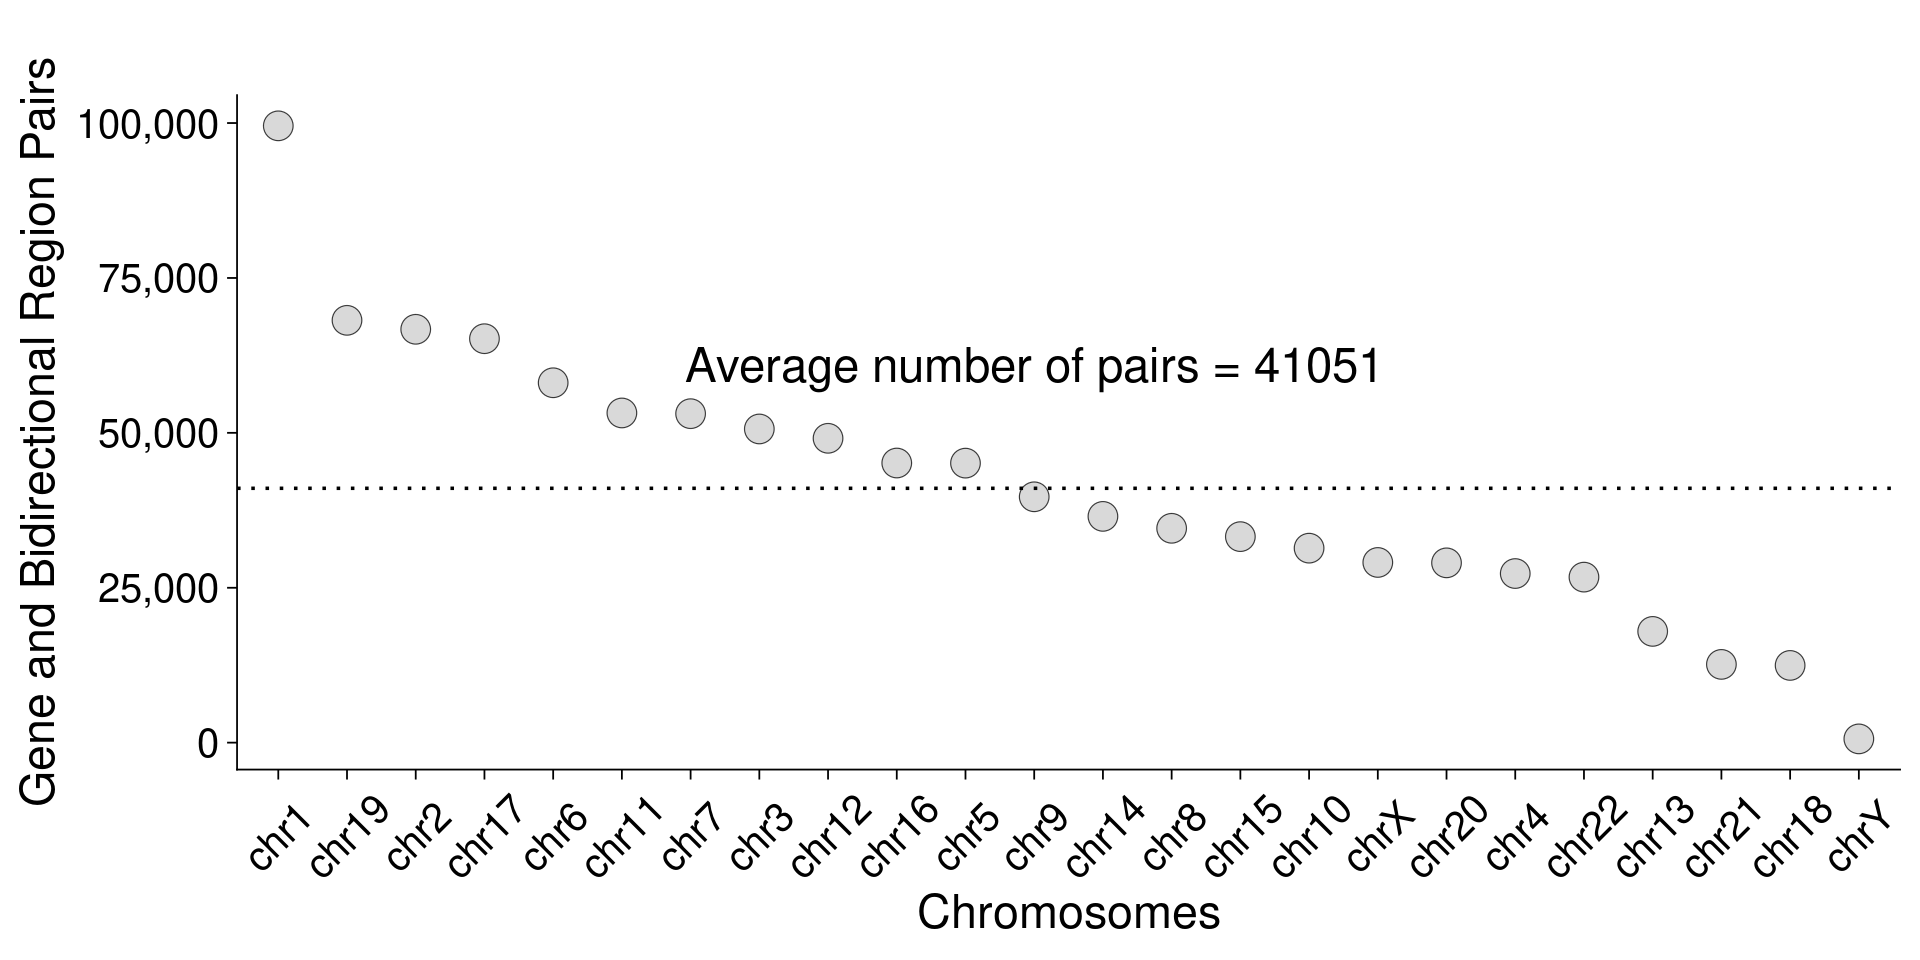

In [19]:
options(repr.plot.width=16, repr.plot.height=8)
num_pairs_plot <- ggplot(num_sig_pairs_inter, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Freq)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=8, 
           fill='gray80',
          color='black') +
geom_hline(yintercept = mean(num_sig_pairs_inter$Freq),
           linetype="dotted", 
           color = "black", 
           size=1) +
ggtitle(" ") +
ylab("Gene and Bidirectional Region Pairs") + 
xlab("Chromosomes") +
annotate(geom="text", x=12, y=mean(num_sig_pairs_inter$Freq)+20000, 
         size=10,
         label=paste0("Average number of pairs = ", 
                      round(mean(num_sig_pairs_inter$Freq))),
         color="black") +
theme_cowplot(24) +
scale_y_continuous(labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24,
                                 angle=45,
                                 hjust=0.5,
                                vjust=0.5),
      axis.text.y = element_text(size = 24)) 

num_pairs_plot

In [20]:
ggsave(num_pairs_plot, width = 16, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_pairs_plot.pdf',
      bg = "transparent")

ggsave(num_pairs_plot, width = 16, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_pairs_plot.png',
      bg = "transparent")

## Bidirectionals assigned to gene

In [21]:
##count the number of pairs regarless of the tissue
num_bidirs_per_gene_inter <- as.data.frame(table(sig_inter_nobs_dist_filtered_unique$transcript_1))
head(num_bidirs_per_gene_inter, 3)

,Var1,Freq
,<fct>,<int>
1,A1BG-AS1:NR_015380.2,27
2,A1BG:NM_130786.4,17
3,A1CF:NM_014576.4,20


In [22]:
#Merge the gene bidir count summaries with transcription metadata for the genes
num_bidirs_per_gene_inter_summary <- merge(gene_bidir_tpm_summary_allBidirs_filteredSamples, 
                                          num_bidirs_per_gene_inter,
                                          by.x='gene_transcript', 
                                          by.y='Var1')

nrow(num_bidirs_per_gene_inter_summary)
head(num_bidirs_per_gene_inter_summary, 3)

[1] 23868

gene_transcript,chrom,start,stop,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,gene_id,Freq
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<int>
A1BG-AS1:NR_015380.2,chr19,58352719,58355183,.,+,2465,4.4725963,20.0041173,3281.04567,4.36890235,3.273834687,1.0237345,39.844387,0,730,97.20373,genes,A1BG-AS1,27
A1BG:NM_130786.4,chr19,58345182,58352742,.,-,7561,0.9376594,0.8792051,777.31837,1.03504444,0.827704724,0.9059122,10.714507,0,749,99.73369,genes,A1BG,17
A1CF:NM_014576.4,chr10,50799408,50884877,.,-,85470,0.5958061,0.3549849,57.06898,0.07599065,0.001479047,7.8405178,8.448126,0,529,70.43941,genes,A1CF,20


In [23]:
gene_bidir_tpm_summary_allBidirs_filteredSamples_genes <- subset(gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                                                transcript_type=='genes')

print(paste("Percent of genes linked to bidirectional =",
            (nrow(num_bidirs_per_gene_inter)/nrow(gene_bidir_tpm_summary_allBidirs_filteredSamples_genes))*100))

[1] "Percent of genes linked to bidirectional = 82.6196822319914"


In [24]:
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}
getmode(num_bidirs_per_gene_inter$Freq)

[1] 27

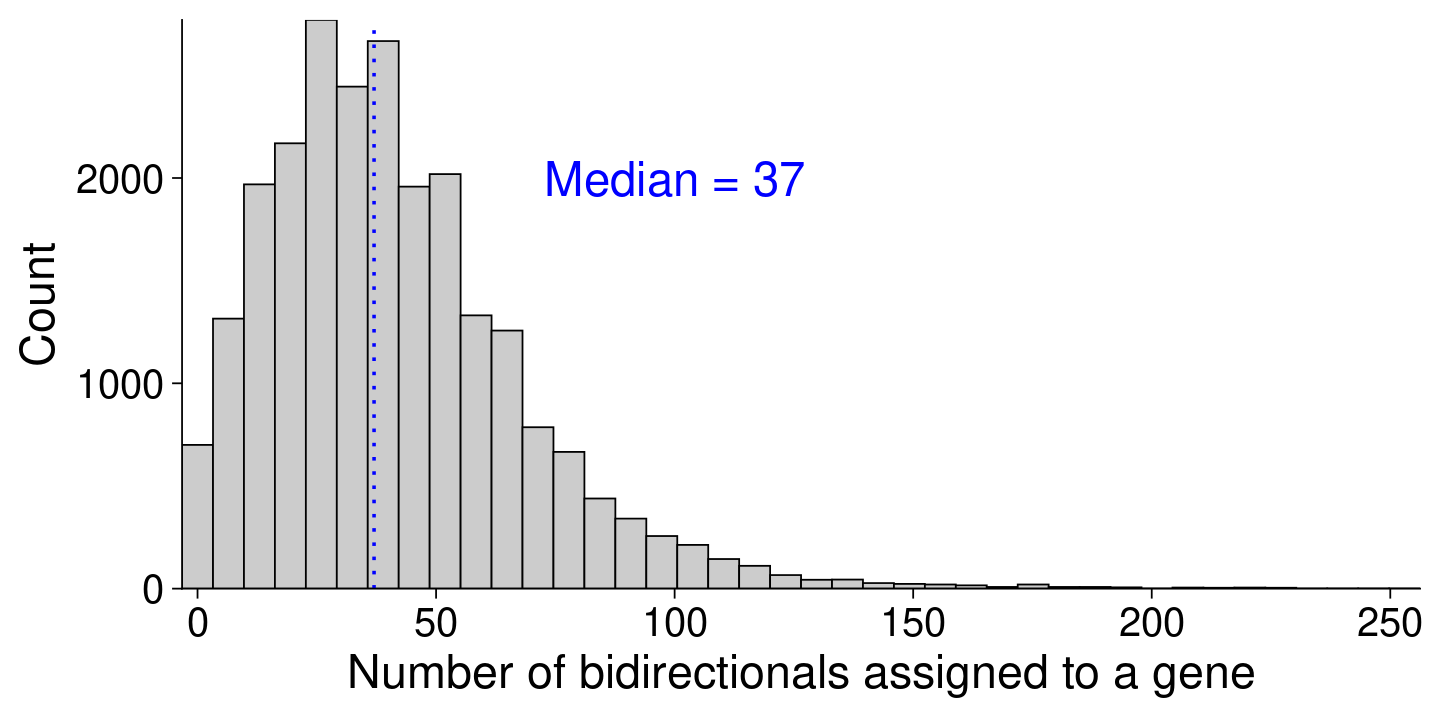

In [25]:
options(repr.plot.width=12, repr.plot.height=6)

num_bidirs_per_gene_inter_plot <- ggplot(num_bidirs_per_gene_inter, aes(x = Freq)) + 
geom_histogram(color="black", fill="gray80", bins=40) +
theme_cowplot(24) + 
geom_vline(xintercept = median(num_bidirs_per_gene_inter$Freq),
           linetype="dotted", 
           color = "blue", 
           size=1) +
annotate(geom="text", x=100, y=2000, 
         size=10,
         label=paste0("Median = ", 
                      round(median(num_bidirs_per_gene_inter$Freq))),
         color="blue") +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
xlab("Number of bidirectionals assigned to a gene") +
ylab("Count") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

num_bidirs_per_gene_inter_plot

In [26]:
ggsave(num_bidirs_per_gene_inter_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_inter_plot.pdf',
      bg = "transparent")

ggsave(num_bidirs_per_gene_inter_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_inter_plot.png',
      bg = "transparent")

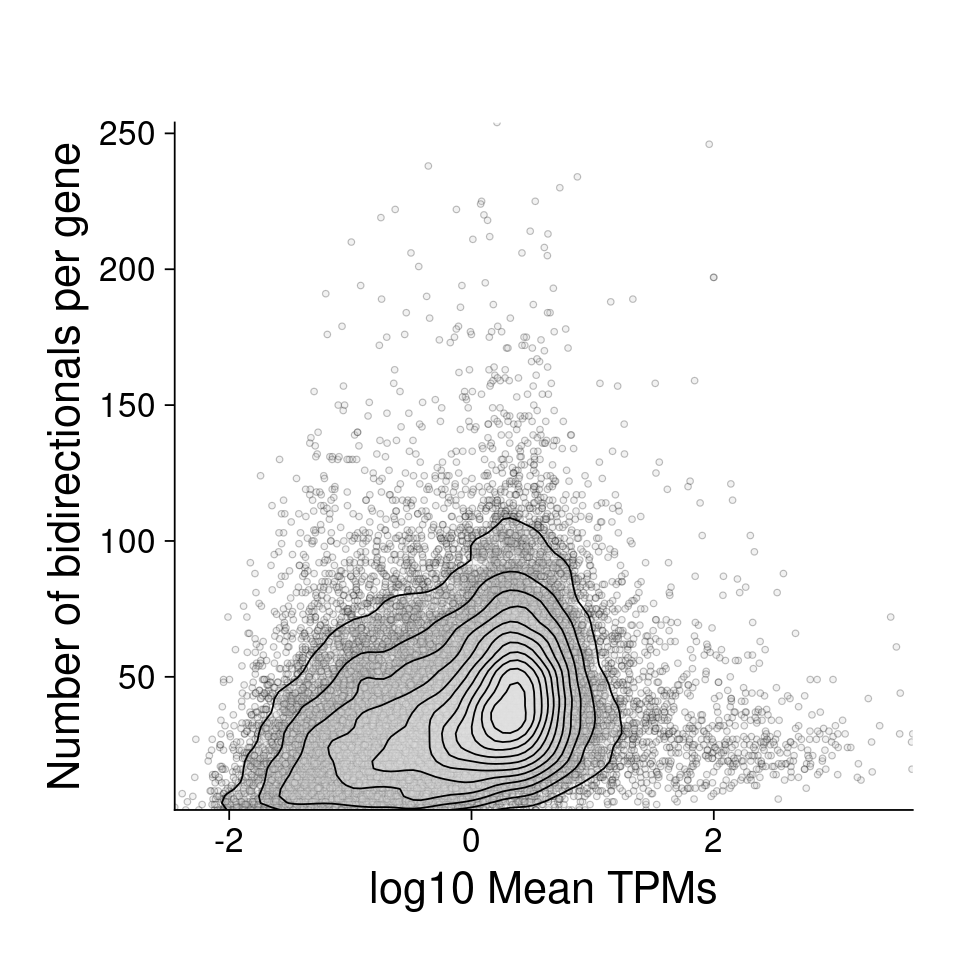

In [27]:
options(repr.plot.width=8, repr.plot.height=8)

num_bidirs_per_gene_inter_tpm_plot <- ggplot(num_bidirs_per_gene_inter_summary, 
       aes(x = log(mean, 10), y = Freq)) + 
geom_point(shape=21,
           color="black", 
           alpha=0.25,
           fill="gray80") +
stat_density_2d(aes(fill = ..level..), 
                alpha=0.25,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle(" ") +
ylab("Number of bidirectionals per gene") +
xlab("log10 Mean TPMs") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

num_bidirs_per_gene_inter_tpm_plot

In [28]:
ggsave(num_bidirs_per_gene_inter_tpm_plot, width = 8, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_inter_tpm_plot.pdf',
      bg = "transparent")

ggsave(num_bidirs_per_gene_inter_tpm_plot, width = 8, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_inter_tpm_plot.png',
      bg = "transparent")

## Genes linked to a bidirectional

In [29]:
##Count the number of genes per bidirections
num_bidirs_per_gene_inter_summary <- merge(gene_bidir_tpm_summary_allBidirs_filteredSamples, 
                                          num_bidirs_per_gene_inter,
                                          by.x='gene_transcript', 
                                          by.y='Var1')

nrow(num_bidirs_per_gene_inter_summary)
head(num_bidirs_per_gene_inter_summary, 3)

[1] 23868

gene_transcript,chrom,start,stop,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,gene_id,Freq
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<int>
A1BG-AS1:NR_015380.2,chr19,58352719,58355183,.,+,2465,4.4725963,20.0041173,3281.04567,4.36890235,3.273834687,1.0237345,39.844387,0,730,97.20373,genes,A1BG-AS1,27
A1BG:NM_130786.4,chr19,58345182,58352742,.,-,7561,0.9376594,0.8792051,777.31837,1.03504444,0.827704724,0.9059122,10.714507,0,749,99.73369,genes,A1BG,17
A1CF:NM_014576.4,chr10,50799408,50884877,.,-,85470,0.5958061,0.3549849,57.06898,0.07599065,0.001479047,7.8405178,8.448126,0,529,70.43941,genes,A1CF,20


In [30]:
num_genes_per_bidir_inter <- as.data.frame(table(sig_inter_nobs_dist_filtered_unique$transcript_2))
head(num_genes_per_bidir_inter, 3)

,Var1,Freq
,<fct>,<int>
1,chr1:1000004-1000574,1
2,chr1:1000642-1001068,1
3,chr1:1001085-1001579,52


In [31]:
num_genes_per_bidir_inter_summary <- merge(gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                           num_genes_per_bidir_inter,
                                          by.x='gene_transcript', 
                                          by.y='Var1')
nrow(num_genes_per_bidir_inter_summary)

[1] 179257

In [32]:
getmode(num_genes_per_bidir_inter$Freq)

[1] 1

In [33]:
gene_bidir_tpm_summary_allBidirs_filteredSamples_bidirs <- subset(gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                                                transcript_type !='genes')

print(paste("Percent of bidirectionals linked to genes =",
            (nrow(num_genes_per_bidir_inter)/nrow(gene_bidir_tpm_summary_allBidirs_filteredSamples_bidirs))*100))

[1] "Percent of bidirectionals linked to genes = 21.1507443473377"


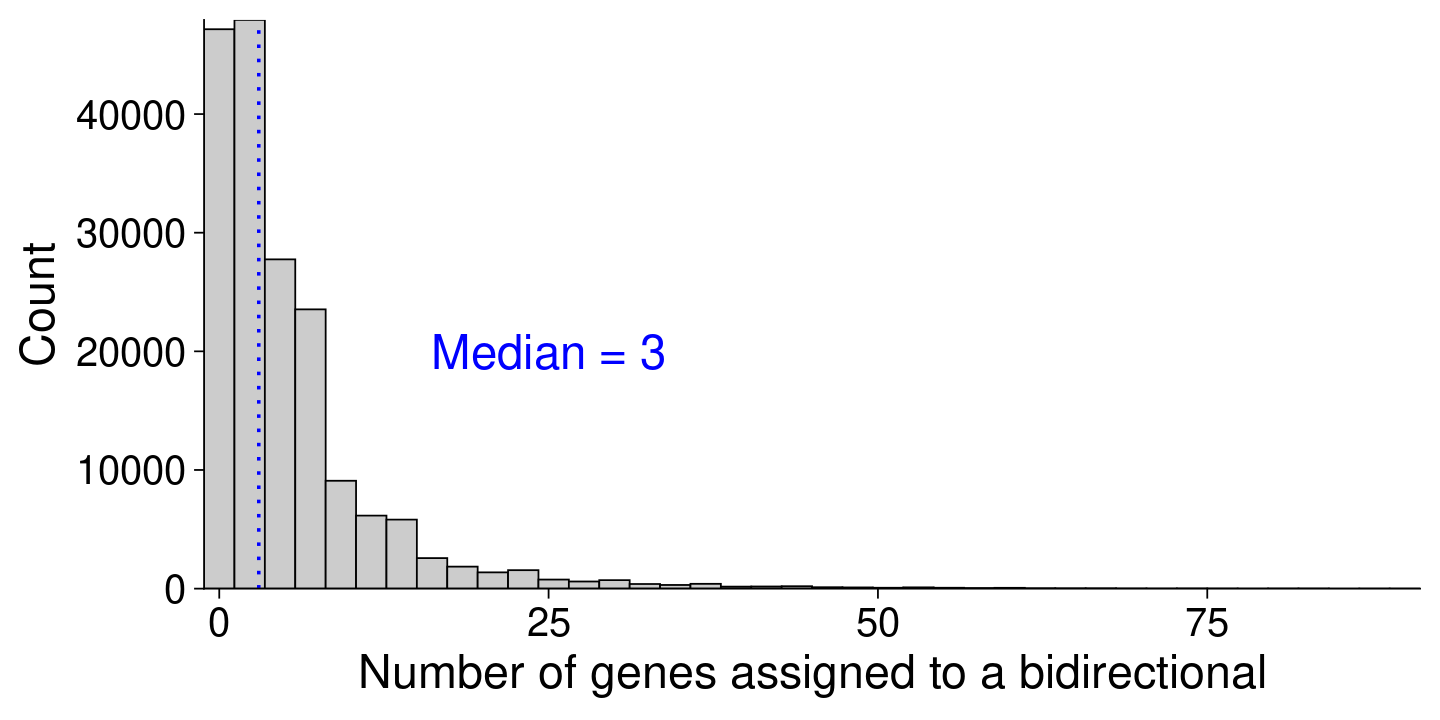

In [34]:
options(repr.plot.width=12, repr.plot.height=6)

num_genes_per_bidir_inter_plot <- ggplot(num_genes_per_bidir_inter, aes(x = Freq)) + 
geom_histogram(color="black", fill="gray80", bins=40) +
theme_cowplot(24) + 
geom_vline(xintercept = median(num_genes_per_bidir_inter$Freq),
           linetype="dotted", 
           color = "blue", 
           size=1) +
annotate(geom="text", x=25, y=20000, 
         size=10,
         label=paste0("Median = ", 
                      round(median(num_genes_per_bidir_inter$Freq))),
         color="blue") +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
xlab("Number of genes assigned to a bidirectional") +
ylab("Count") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

num_genes_per_bidir_inter_plot

In [35]:
ggsave(num_genes_per_bidir_inter_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_genes_per_bidir_inter_plot.pdf',
      bg = "transparent")

ggsave(num_genes_per_bidir_inter_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_genes_per_bidir_inter_plot.png',
      bg = "transparent")

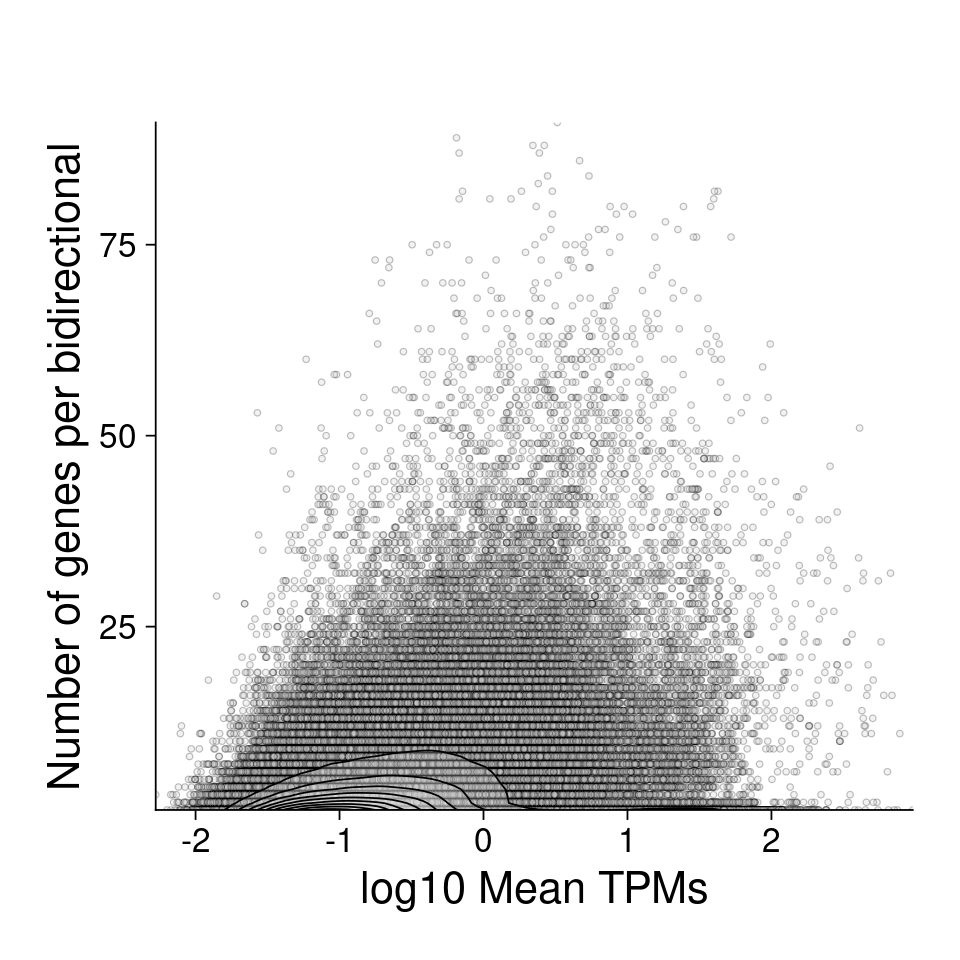

In [36]:
options(repr.plot.width=8, repr.plot.height=8)

num_genes_per_bidir_inter_tpm_plot <- ggplot(num_genes_per_bidir_inter_summary, 
       aes(x = log(mean, 10), y = Freq)) + 
geom_point(shape=21,
           color="black", 
           alpha=0.25,
           fill="gray80") +
stat_density_2d(aes(fill = ..level..), 
                alpha=0.25,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle(" ") +
ylab("Number of genes per bidirectional") +
xlab("log10 Mean TPMs") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

num_genes_per_bidir_inter_tpm_plot

## Number of tissues a pair is found

In [37]:
no_tissues_for_pair_inter <- as.data.frame(table(sig_inter_nobs_dist_filtered_promoters$pair_id))
nrow(no_tissues_for_pair_inter)
head(no_tissues_for_pair_inter, 3)

[1] 985218

,Var1,Freq
,<fct>,<int>
1,A1BG-AS1:NR_015380.2~chr19:57479710-57479990,1
2,A1BG-AS1:NR_015380.2~chr19:57480338-57480600,2
3,A1BG-AS1:NR_015380.2~chr19:57484184-57485124,1


In [38]:
no_tissues_for_pair_inter$gene_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair_inter$Var1), ':'),
                                                      `[`, 1))
no_tissues_for_pair_inter$bidir_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair_inter$Var1), '~'),
                                                      `[`, 2))
head(no_tissues_for_pair_inter, 3)


,Var1,Freq,gene_id,bidir_id
,<fct>,<int>,<chr>,<chr>
1,A1BG-AS1:NR_015380.2~chr19:57479710-57479990,1,A1BG-AS1,chr19:57479710-57479990
2,A1BG-AS1:NR_015380.2~chr19:57480338-57480600,2,A1BG-AS1,chr19:57480338-57480600
3,A1BG-AS1:NR_015380.2~chr19:57484184-57485124,1,A1BG-AS1,chr19:57484184-57485124


In [39]:
no_tissues_for_pair_inter_summary <- merge(no_tissues_for_pair_inter, 
                                          gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                          by='gene_id')
nrow(no_tissues_for_pair_inter_summary)
head(no_tissues_for_pair_inter_summary, 3)

[1] 985218

,gene_id,Var1,Freq,bidir_id,chrom,start,stop,gene_transcript,score,strand,⋯,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type
,<chr>,<fct>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
1,A1BG,A1BG:NM_130786.4~chr19:57479710-57479990,1,chr19:57479710-57479990,chr19,58345182,58352742,A1BG:NM_130786.4,.,-,⋯,0.8792051,777.3184,1.035044,0.8277047,0.9059122,10.71451,0,749,99.73369,genes
2,A1BG,A1BG:NM_130786.4~chr19:57480338-57480600,1,chr19:57480338-57480600,chr19,58345182,58352742,A1BG:NM_130786.4,.,-,⋯,0.8792051,777.3184,1.035044,0.8277047,0.9059122,10.71451,0,749,99.73369,genes
3,A1BG,A1BG:NM_130786.4~chr19:57483860-57484152,1,chr19:57483860-57484152,chr19,58345182,58352742,A1BG:NM_130786.4,.,-,⋯,0.8792051,777.3184,1.035044,0.8277047,0.9059122,10.71451,0,749,99.73369,genes


In [40]:
no_tissues_for_pair_counts_inter <- as.data.frame(table(no_tissues_for_pair_inter$Freq))
no_tissues_for_pair_counts_inter$Percent <- 100*(no_tissues_for_pair_counts_inter$Freq/sum(no_tissues_for_pair_counts_inter$Freq))
no_tissues_for_pair_counts_inter

Var1,Freq,Percent
<fct>,<int>,<dbl>
1,780853,79.256875128
2,148964,15.119902397
3,36694,3.724454892
4,11687,1.186234925
5,4299,0.436350128
6,1621,0.164532114
7,680,0.069020257
8,273,0.027709603
9,113,0.011469543


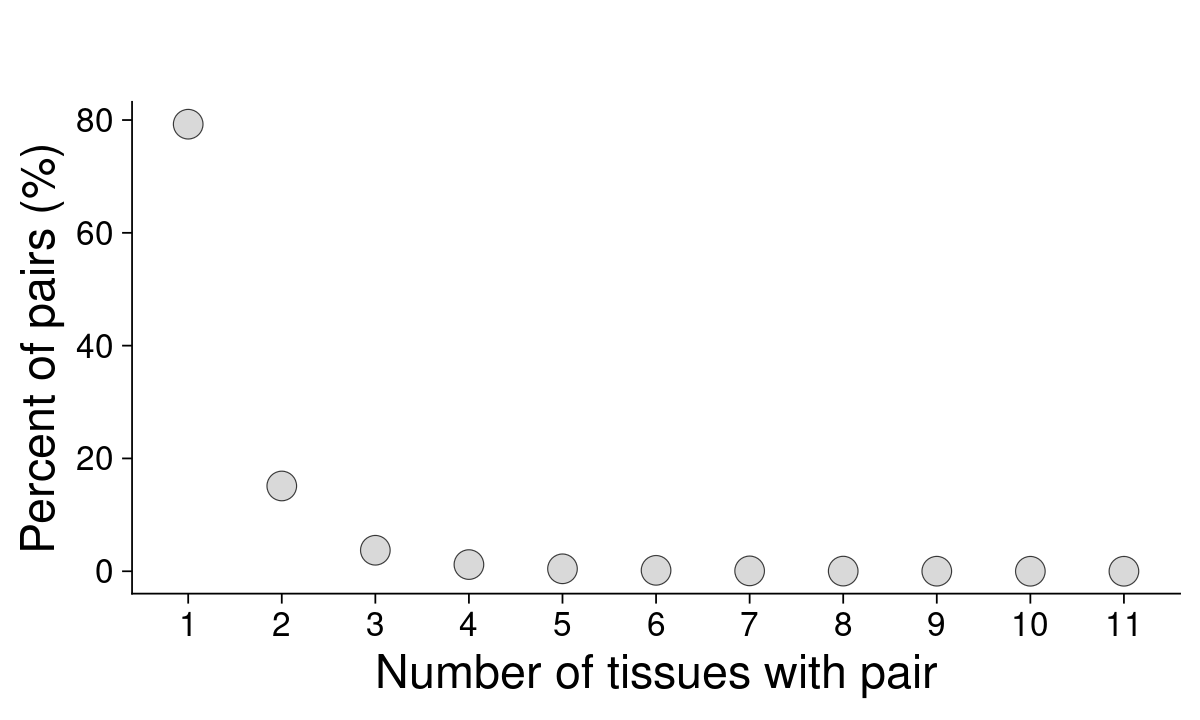

In [41]:
options(repr.plot.width=10, repr.plot.height=6)
num_tissues_pairs_plot <- ggplot(no_tissues_for_pair_counts_inter, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=8, 
           fill='gray80',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
scale_y_continuous(labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_plot

In [42]:
ggsave(num_tissues_pairs_plot, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_pairs_per_tissue_plot.pdf',
      bg = "transparent")

ggsave(num_tissues_pairs_plot, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_pairs_per_tissue_plot.png',
      bg = "transparent")

In [43]:
seq(1, nrow(no_tissues_for_pair_counts_inter), 1)

[1]  1  2  3  4  5  6  7  8  9 10 11

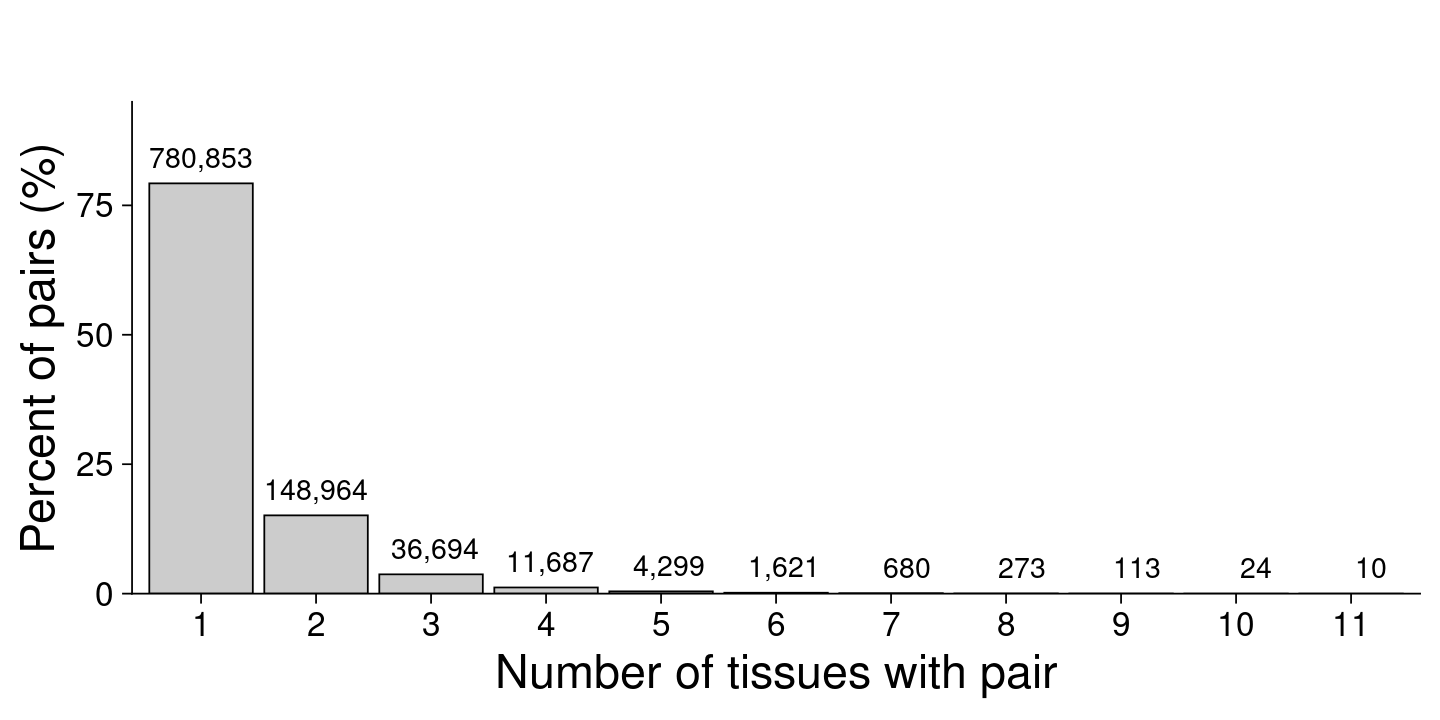

In [44]:
options(repr.plot.width=12, repr.plot.height=6)
num_tissues_pairs_bar_plot <- ggplot(no_tissues_for_pair_counts_inter, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_bar(stat='identity',
         fill='gray80',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
annotate("text", x=seq(1, nrow(no_tissues_for_pair_counts_inter), 1),
         y=no_tissues_for_pair_counts_inter$Percent+5, 
         label= format(no_tissues_for_pair_counts_inter$Freq, 
       scientific = FALSE, big.mark = ','), size = 6) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,95)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_bar_plot

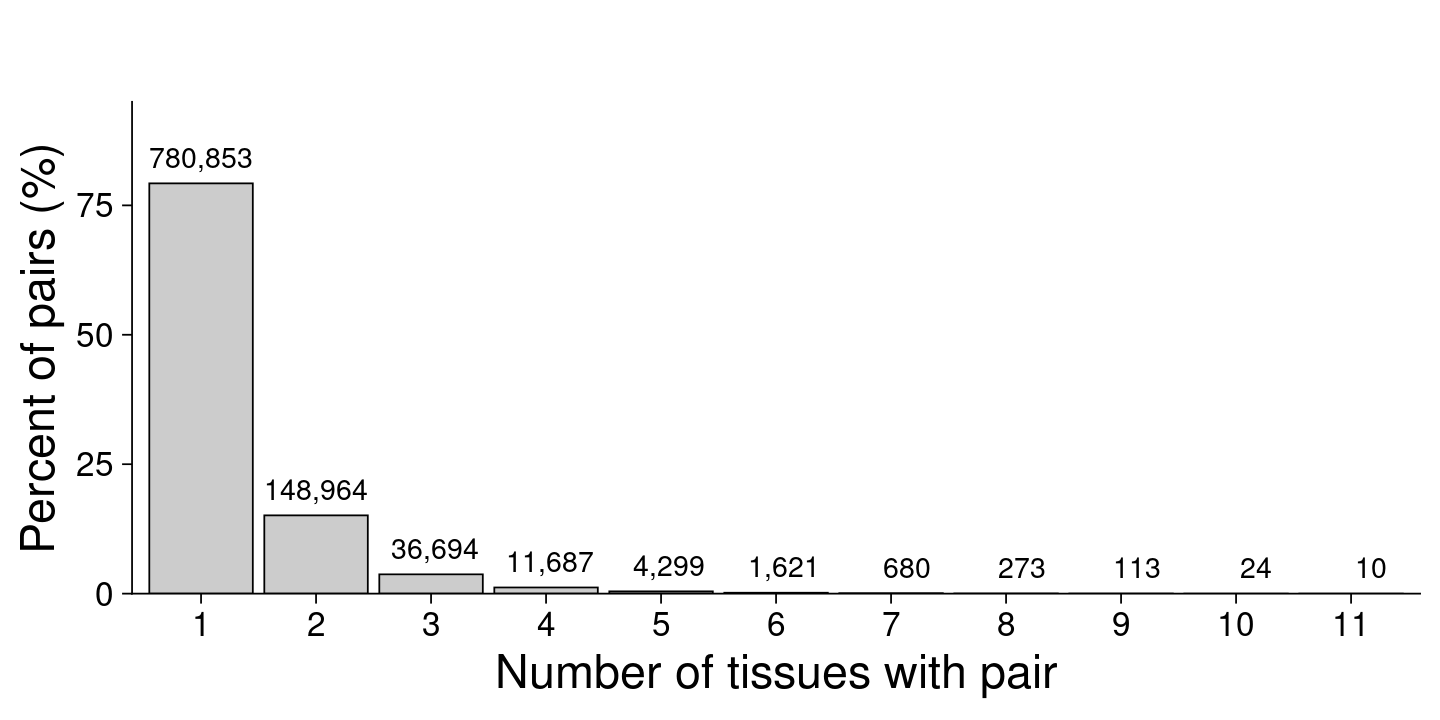

In [45]:
options(repr.plot.width=12, repr.plot.height=6)
num_tissues_pairs_bar_plot <- ggplot(no_tissues_for_pair_counts_inter, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_bar(stat='identity',
         fill='gray80',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
annotate("text", x=seq(1, nrow(no_tissues_for_pair_counts_inter), 1),
         y=no_tissues_for_pair_counts_inter$Percent+5, 
         label= format(no_tissues_for_pair_counts_inter$Freq, 
       scientific = FALSE, big.mark = ','), size = 6) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,95)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_bar_plot

In [46]:
ggsave(num_tissues_pairs_bar_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_tissues_pairs_bar_plot_all.pdf',
      bg = "transparent")

ggsave(num_tissues_pairs_bar_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_tissues_pairs_bar_plot_all.png',
      bg = "transparent")

In [47]:
no_tissues_for_pair_counts_inter_greater5 <- no_tissues_for_pair_counts_inter[no_tissues_for_pair_counts_inter$Var1 %in%
                                                                            c(5,6,7,8,9,10,11),]
no_tissues_for_pair_counts_inter_greater5
sum(no_tissues_for_pair_counts_inter_greater5$Freq)

,Var1,Freq,Percent
,<fct>,<int>,<dbl>
5,5,4299,0.436350128
6,6,1621,0.164532114
7,7,680,0.069020257
8,8,273,0.027709603
9,9,113,0.011469543
10,10,24,0.002436009
11,11,10,0.001015004


[1] 7020

In [48]:
no_tissues_for_pair_counts_inter_new_set <- rbind(no_tissues_for_pair_counts_inter[!no_tissues_for_pair_counts_inter$Var1 %in%
                                                                            c(5,6,7,8,9,10,11),],
                                                 data.frame(Var1=c(">=5"),
                                                            Freq=sum(no_tissues_for_pair_counts_inter_greater5$Freq),
                                                            Percent=sum(no_tissues_for_pair_counts_inter_greater5$Percent)))
no_tissues_for_pair_counts_inter_new_set

Var1,Freq,Percent
<fct>,<int>,<dbl>
1,780853,79.2568751
2,148964,15.1199024
3,36694,3.7244549
4,11687,1.1862349
>=5,7020,0.7125327


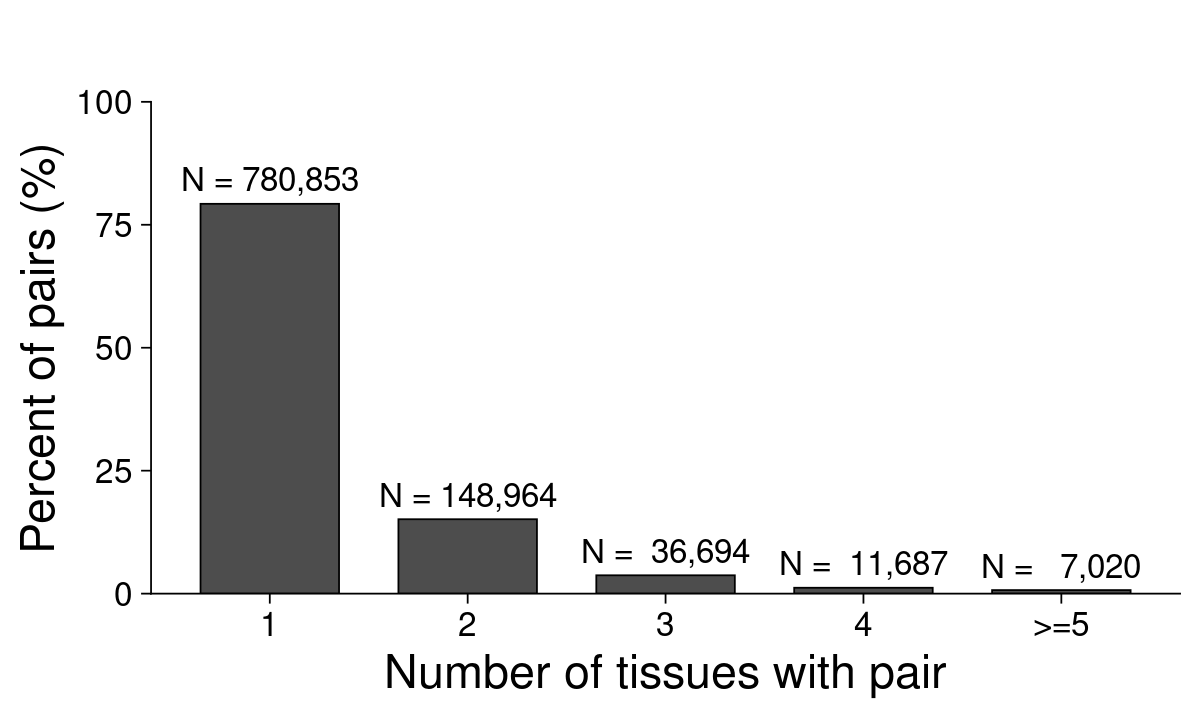

In [49]:
options(repr.plot.width=10, repr.plot.height=6)
num_tissues_pairs_bar_plot2 <- ggplot(no_tissues_for_pair_counts_inter_new_set, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_bar(stat='identity',
         width=0.7,
         fill='gray30',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
annotate("text", x=c(1,2,3,4,5),
         y=no_tissues_for_pair_counts_inter_new_set$Percent+5, 
         label= paste("N =", format(no_tissues_for_pair_counts_inter_new_set$Freq, 
       scientific = FALSE, big.mark = ',')), size = 7) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,100)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_bar_plot2

In [50]:
ggsave(num_tissues_pairs_bar_plot2, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_pairs_per_tissue_bar_plot.pdf',
      bg = "transparent")

ggsave(num_tissues_pairs_bar_plot2, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_pairs_per_tissue_bar_plot.png',
      bg = "transparent")

### How many genes have pairs based in tissues that recover a pair?

In [51]:
number_of_tissues <- seq(1,11,1)
number_of_tissues

n_pairs_list <- list()
n_genes_list <- list()
n_bidirs_list <- list()
p_genes_list <- list()
p_bidirs_list <- list()


for (i in 1: length(number_of_tissues)){
    
    print("---------------------------------------")
    print(paste("N Tissues >=",(i)))
    
    no_tissues_for_pair_inter_filt <- subset(no_tissues_for_pair_inter,
                                             Freq >= as.numeric(number_of_tissues[[i]]))
    
    n_pairs <- nrow(no_tissues_for_pair_inter_filt)
    n_pairs_list[[i]] <- n_pairs
    print(paste("Number of pairs = ", 
          n_pairs))
    
    n_genes <- length(unique(no_tissues_for_pair_inter_filt$gene_id))
    print(paste("Number of genes = ", 
          n_genes))
    n_genes_list[[i]] <- n_genes
    
    p_genes <- (length(unique(no_tissues_for_pair_inter_filt$gene_id))/nrow(gene_bidir_tpm_summary_allBidirs_filteredSamples_genes))*100
    print(paste("Percent of genes =",
          p_genes))
    p_genes_list[[i]] <- p_genes
    
    n_bidirs <- length(unique(no_tissues_for_pair_inter_filt$bidir_id))
    print(paste("Number of bidirectionals = ", 
          n_bidirs))
    n_bidirs_list[[i]] <- n_bidirs
    
    p_bidirs <- (length(unique(no_tissues_for_pair_inter_filt$bidir_id))/nrow(gene_bidir_tpm_summary_allBidirs_filteredSamples_bidirs))*100
    print(paste("Percent of bidirectionals =",
         p_bidirs))
    p_bidirs_list[[i]] <- p_bidirs
   
}


[1]  1  2  3  4  5  6  7  8  9 10 11

[1] "---------------------------------------"
[1] "N Tissues >= 1"
[1] "Number of pairs =  985218"
[1] "Number of genes =  23868"
[1] "Percent of genes = 82.6196822319914"
[1] "Number of bidirectionals =  179257"
[1] "Percent of bidirectionals = 21.1507443473377"
[1] "---------------------------------------"
[1] "N Tissues >= 2"
[1] "Number of pairs =  204365"
[1] "Number of genes =  20795"
[1] "Percent of genes = 71.9824154522483"
[1] "Number of bidirectionals =  66884"
[1] "Percent of bidirectionals = 7.89172185703953"
[1] "---------------------------------------"
[1] "N Tissues >= 3"
[1] "Number of pairs =  55401"
[1] "Number of genes =  14171"
[1] "Percent of genes = 49.0532728720274"
[1] "Number of bidirectionals =  24248"
[1] "Percent of bidirectionals = 2.86105005067721"
[1] "---------------------------------------"
[1] "N Tissues >= 4"
[1] "Number of pairs =  18707"
[1] "Number of genes =  7483"
[1] "Percent of genes = 25.9025926823358"
[1] "Number of bidirectionals =  10053"
[

In [52]:
filtered_tissues_transcript_summ <- tibble(number_of_tissues,
                                           as.numeric(n_pairs_list),
                                           as.numeric(n_genes_list), 
                                           as.numeric(p_genes_list), 
                                           as.numeric(n_bidirs_list), 
                                           as.numeric(p_bidirs_list))
colnames(filtered_tissues_transcript_summ) <- c('num_tissues',
                                               'num_pairs',
                                               'num_genes',
                                               'perc_genes',
                                               'num_bidirs',
                                               'perc_bidirs')
filtered_tissues_transcript_summ$perc_pairs <- (filtered_tissues_transcript_summ$num_pairs/nrow(sig_inter_nobs_dist_filtered_unique))*100

filtered_tissues_transcript_summ

num_tissues,num_pairs,num_genes,perc_genes,num_bidirs,perc_bidirs,perc_pairs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,985218,23868,82.61968223,179257,21.150744347,1.000000e+02
2,204365,20795,71.98241545,66884,7.891721857,2.074312e+01
3,55401,14171,49.05327287,24248,2.861050051,5.623222e+00
4,18707,7483,25.90259268,10053,1.186165299,1.898768e+00
5,7020,3558,12.31610648,4440,0.523880824,7.125327e-01
6,2721,1628,5.63536294,2020,0.238342177,2.761825e-01
7,1100,730,2.52691336,934,0.110203759,1.116504e-01
8,420,299,1.03499602,386,0.045544594,4.263016e-02
9,147,113,0.39115234,142,0.016754747,1.492056e-02


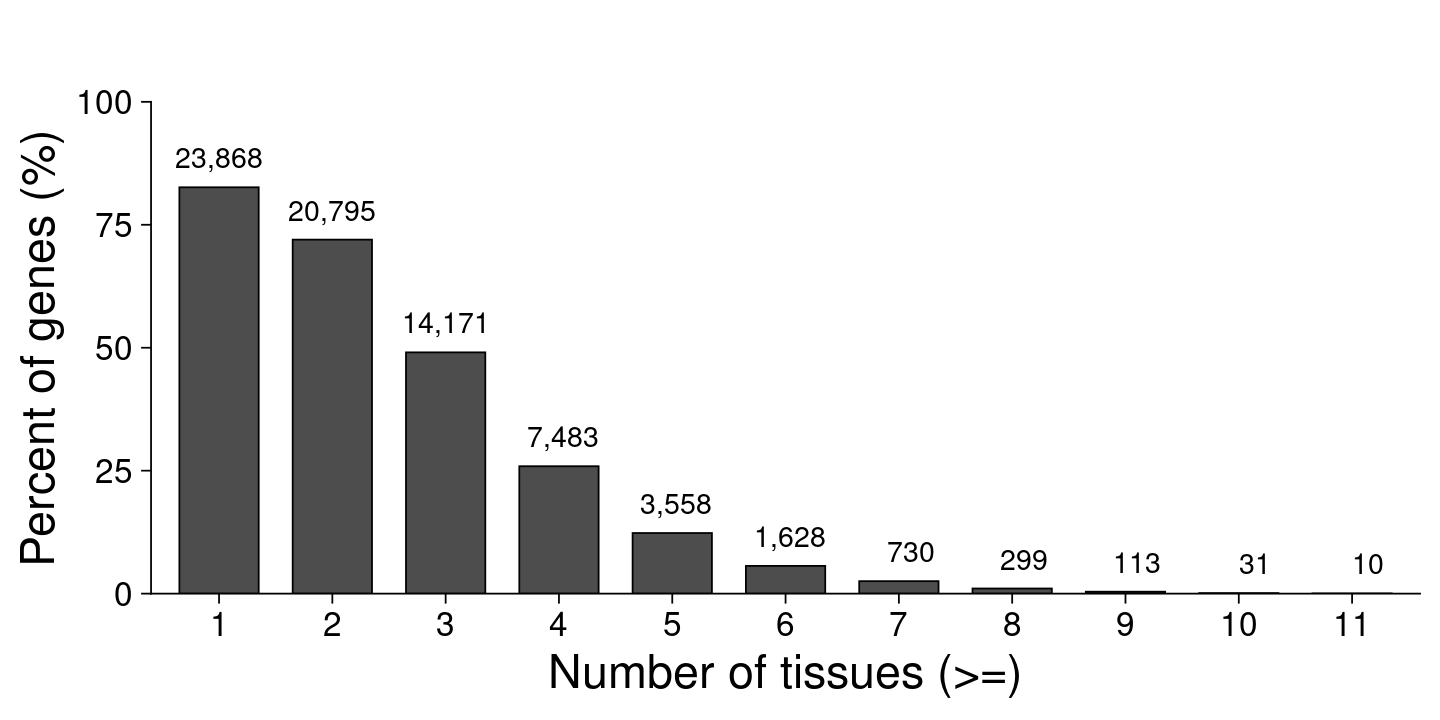

In [53]:
options(repr.plot.width=12, repr.plot.height=6)
num_genes_per_tissues_plot <- ggplot(filtered_tissues_transcript_summ, 
                       aes(x=reorder(num_tissues, -num_pairs), 
                           y=perc_genes)) + 
geom_bar(stat='identity',
         width=0.7,
         fill='gray30',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues (>=)") + 
ylab("Percent of genes (%)") +
theme_cowplot(24) +
annotate("text", x=number_of_tissues,
         y=filtered_tissues_transcript_summ$perc_genes+6, 
         label= format(filtered_tissues_transcript_summ$num_genes, 
       scientific = FALSE, big.mark = ','), size = 6) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,100)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_genes_per_tissues_plot 

In [54]:
ggsave(num_genes_per_tissues_plot, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_genes_per_tissues_plot.pdf',
      bg = "transparent")

ggsave(num_genes_per_tissues_plot, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_genes_per_tissues_plot.png',
      bg = "transparent")

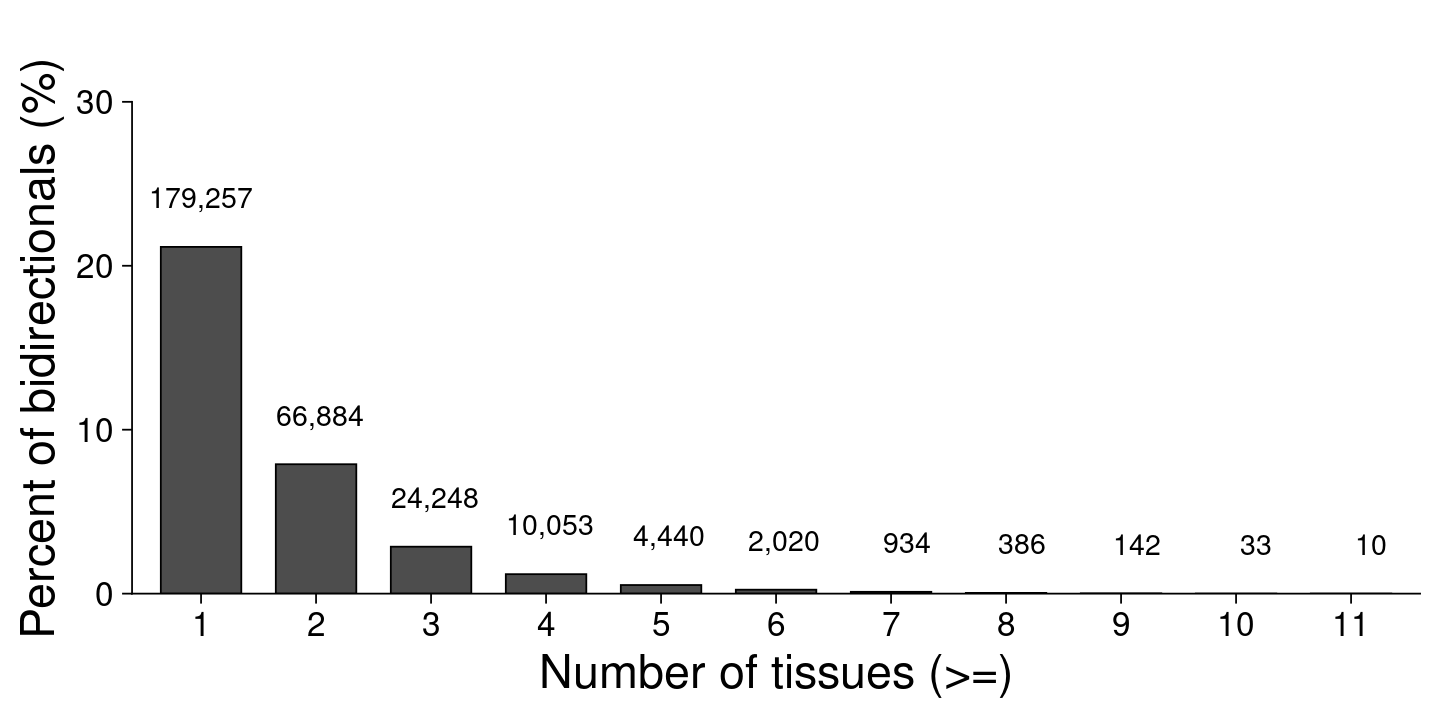

In [55]:
options(repr.plot.width=12, repr.plot.height=6)
num_bidirs_per_tissues_plot <- ggplot(filtered_tissues_transcript_summ, 
                       aes(x=reorder(num_tissues, -num_pairs), 
                           y=perc_bidirs)) + 
geom_bar(stat='identity',
         width=0.7,
         fill='gray30',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues (>=)") + 
ylab("Percent of bidirectionals (%)") +
theme_cowplot(24) +
annotate("text", x=number_of_tissues,
         y=filtered_tissues_transcript_summ$perc_bidirs+3, 
         label= format(filtered_tissues_transcript_summ$num_bidirs, 
       scientific = FALSE, big.mark = ','), size = 6) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,30)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_bidirs_per_tissues_plot

In [56]:
ggsave(num_bidirs_per_tissues_plot, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_tissues_plot.pdf',
      bg = "transparent")

ggsave(num_bidirs_per_tissues_plot, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_tissues_plot.png',
      bg = "transparent")

### Number of tissues a pair is found vs. PCC

In [57]:
no_tissues_for_pair_corr_summary <- merge(no_tissues_for_pair_inter, 
                                          sig_inter_nobs_dist_filtered_promoters,
                                          by.x='Var1',
                                          by.y='pair_id')
nrow(no_tissues_for_pair_corr_summary)
head(no_tissues_for_pair_corr_summary, 3)

[1] 1275143

,Var1,Freq,gene_id,bidir_id,transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,promoter
,<fct>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,A1BG-AS1:NR_015380.2~chr19:57479710-57479990,1,A1BG-AS1,chr19:57479710-57479990,chr19,58351969,58355183,A1BG-AS1:NR_015380.2,.,+,⋯,2.399627e-04,0.0034719478,26,4.310259,-872119,-875333,upstream,uterus,44.82759,candidate_enhancer
2,A1BG-AS1:NR_015380.2~chr19:57480338-57480600,2,A1BG-AS1,chr19:57480338-57480600,chr19,58351969,58355183,A1BG-AS1:NR_015380.2,.,+,⋯,4.493555e-05,0.0009361908,23,5.122232,-871500,-874714,upstream,uterus,39.65517,candidate_enhancer
3,A1BG-AS1:NR_015380.2~chr19:57480338-57480600,2,A1BG-AS1,chr19:57480338-57480600,chr19,58351969,58355183,A1BG-AS1:NR_015380.2,.,+,⋯,1.698483e-04,0.0017483223,18,4.871192,-871500,-874714,upstream,prostate,43.90244,candidate_enhancer


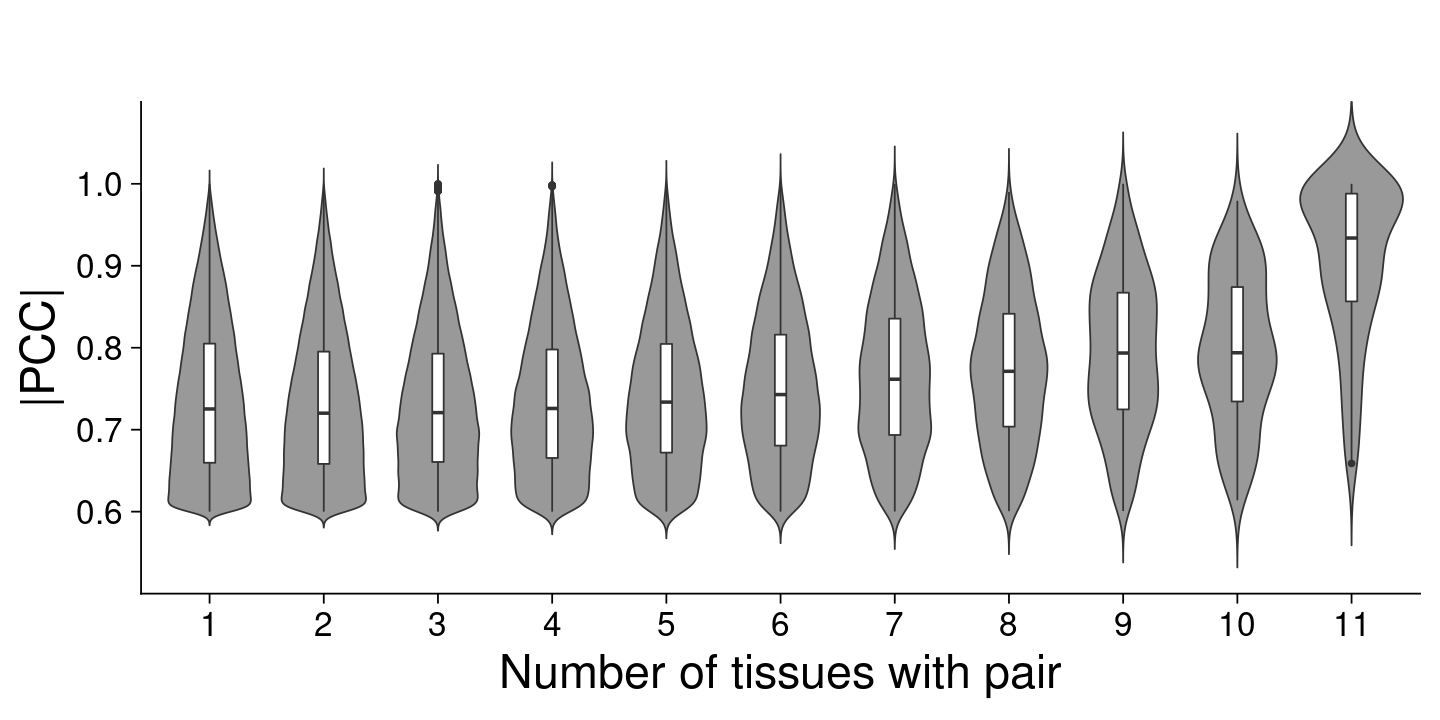

In [58]:
options(repr.plot.width=12, repr.plot.height=6)
pcc_vs_tissue <- ggplot(no_tissues_for_pair_corr_summary, 
                        aes(x=as.factor(Freq), y=abs(pcc))) + 
                  geom_violin(trim=FALSE, fill="gray60")+
                  labs(title=" ",x="Number of tissues with pair", y = "|PCC|")+
                  geom_boxplot(width=0.1)+
                  theme_cowplot(24) +
                  scale_y_continuous(expand = c(0, 0), 
                                     breaks = seq(0.6, 1, 0.1),
                                     limits=c(0.5,1.1)) +
                  theme(plot.title = element_text(hjust = 0.5),
                      title = element_text(size = 34), 
                      axis.title = element_text(size = 28), 
                      axis.text.x = element_text(size = 20),
                      axis.text.y = element_text(size = 20)) 

pcc_vs_tissue 

In [59]:
ggsave(pcc_vs_tissue, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/pcc_vs_tissue.pdf',
      bg = "transparent")

ggsave(pcc_vs_tissue, width = 10, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/pcc_vs_tissue.png',
      bg = "transparent")

# Summary of pairs : By Tissue

## Bidirectionals assigned to gene 

In [60]:
unique(sig_inter_nobs_dist_filtered$tissue)

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical_cord" "uterus"

In [61]:
tissues <- unique(sig_inter_nobs_dist_filtered$tissue)

hist_plot_list <- vector(mode='list', 
                            length=length(tissues))

for (i in 1:length(tissues)){
    
    print("-----------------------------------------------")
    print(paste("Tissue :",tissues[i]))
    
    
    #sig_tissue_filtered <- subset(sig_inter_nobs_dist_filtered, tissue == tissues[i])
    sig_tissue_filtered <- subset(sig_inter_nobs_dist_filtered_promoters, tissue == tissues[i])
    
    ##get pairs
    sig_tissue_filtered_unique <- unique(sig_tissue_filtered[,c('transcript1_chrom', 
                                                            'pair_id',
                                                            'transcript_1', 
                                                            'transcript_2')])

    ##count the number of bidirs per gene
    num_bidirs_per_gene_tissue <- as.data.frame(table(sig_tissue_filtered_unique$transcript_1))

    print(paste("Median bidirectionals assigned = ", 
                round(median(num_bidirs_per_gene_tissue$Freq))))
    
    num_bidirs_per_gene_tissue_plot <- ggplot(num_bidirs_per_gene_tissue, aes(x = Freq)) + 
    geom_histogram(color="black", fill="gray80", bins=40) +
    theme_cowplot(24) + 
    geom_vline(xintercept = median(num_bidirs_per_gene_tissue$Freq),
               linetype="dotted", 
               color = "blue", 
               size=1) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    ggtitle(tissues[i]) +
    xlab("Bidirectional regions assigned to a gene") +
    ylab("Count") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.title = element_text(hjust = 0.5),
          title = element_text(size = 30), 
          axis.title = element_text(size = 26), 
          axis.text.x = element_text(size = 24),
          axis.text.y = element_text(size = 24)) 
    
    #add median counts 
    num_bidirs_per_gene_tissue_plot2 <- num_bidirs_per_gene_tissue_plot + annotate(geom="text", 
                                          x=round(0.5*max(num_bidirs_per_gene_tissue$Freq)), 
                                          y=round(0.5*max(ggplot_build(num_bidirs_per_gene_tissue_plot)$data[[1]]$count)), 
                                          size=10,
                                          label=paste0("Median = ", 
                                                       round(median(num_bidirs_per_gene_tissue$Freq))),
                                          color="blue")
    
    hist_plot_list[[i]] <- num_bidirs_per_gene_tissue_plot2
    
    print("-----------------------------------------------")
}

[1] "-----------------------------------------------"
[1] "Tissue : blood"
[1] "Median bidirectionals assigned =  8"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : breast"
[1] "Median bidirectionals assigned =  3"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : embryo"
[1] "Median bidirectionals assigned =  2"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : heart"
[1] "Median bidirectionals assigned =  3"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : intestine"
[1] "Median bidirectionals assigned =  6"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : kidney"
[1] "Median bidirectionals assigned =  6"
[1] "----------------

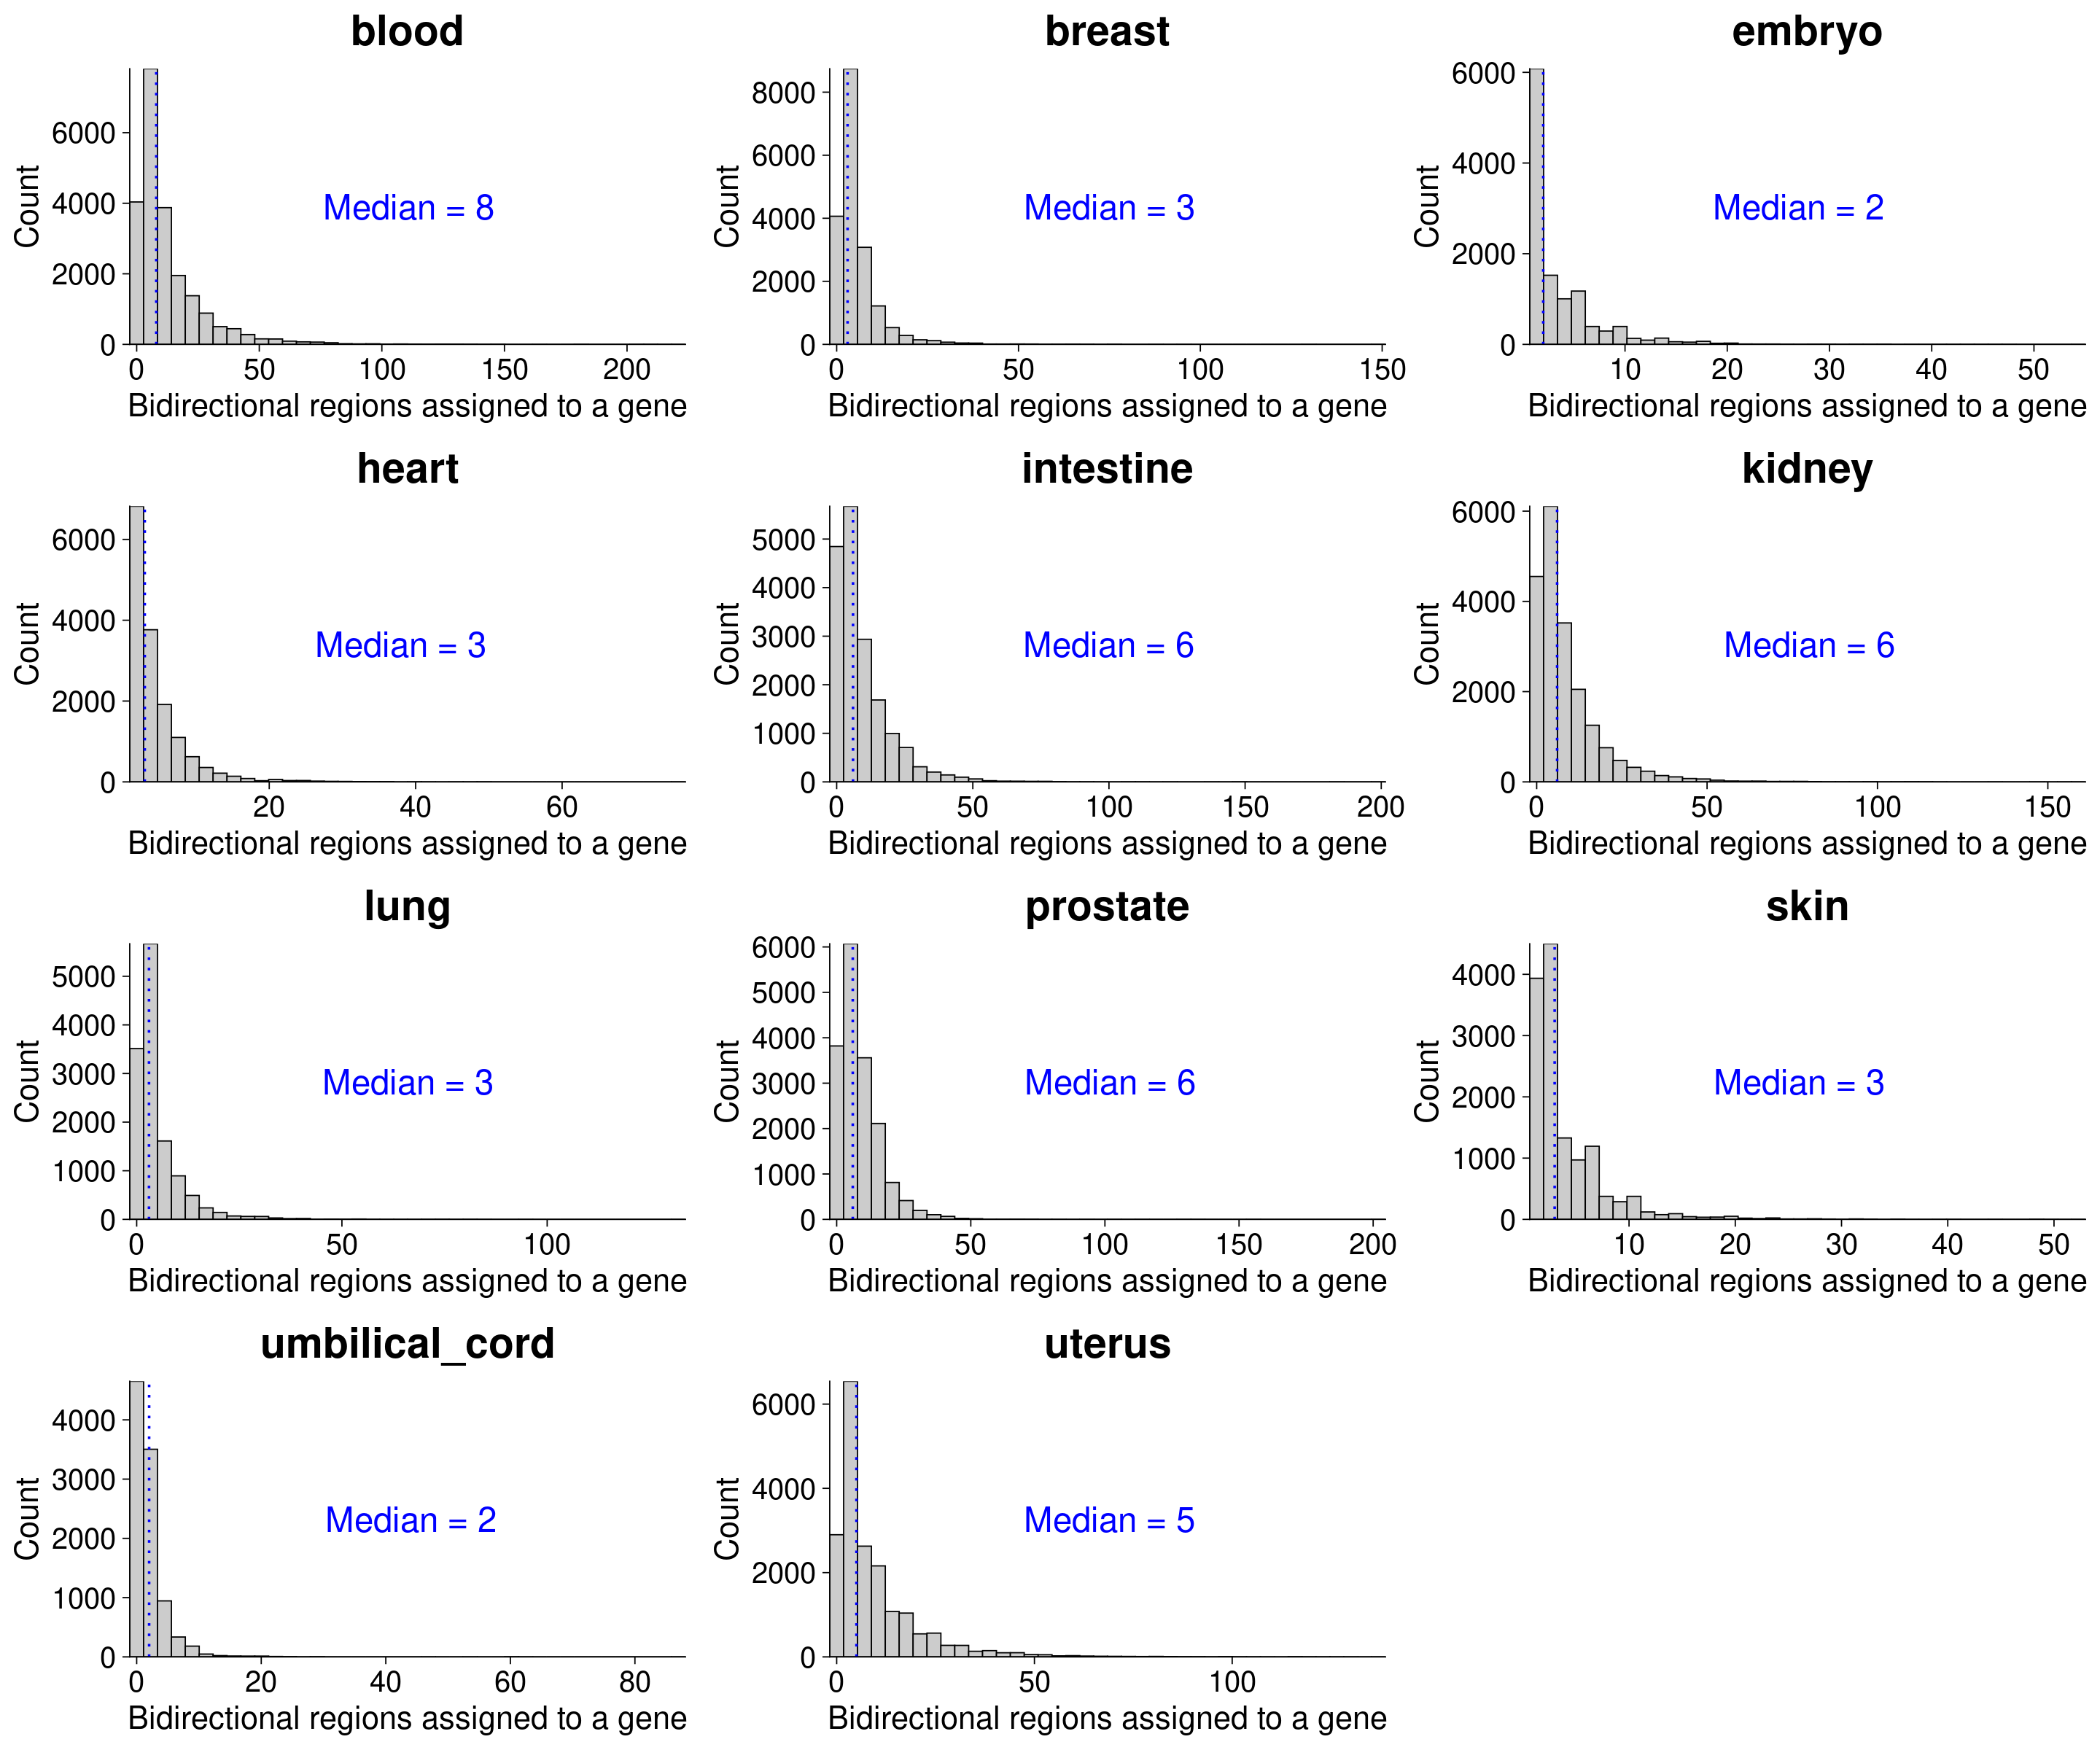

In [62]:
options(repr.plot.width=24, repr.plot.height=20)
num_bidirs_per_gene_all_tissues <- cowplot::plot_grid(plotlist = hist_plot_list, ncol = 3)
num_bidirs_per_gene_all_tissues

In [63]:
ggsave(num_bidirs_per_gene_all_tissues, width = 24, height = 20,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_all_tissues_plot.pdf',
      bg = "transparent")

ggsave(num_bidirs_per_gene_all_tissues, width = 24, height = 20,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_all_tissues_plot.png',
      bg = "transparent")

## Genes linked to a bidirectional

In [64]:

gene_hist_plot_list <- vector(mode='list', 
                            length=length(tissues))

for (i in 1:length(tissues)){
    
    print("-----------------------------------------------")
    print(paste("Tissue :",tissues[i]))
    
    
    sig_tissue_filtered <- subset(sig_inter_nobs_dist_filtered, tissue == tissues[i])
    
    ##get pairs
    sig_tissue_filtered_unique <- unique(sig_tissue_filtered[,c('transcript1_chrom', 
                                                            'pair_id',
                                                            'transcript_1', 
                                                            'transcript_2')])

    ##count the number of bidirs per gene
    num_genes_per_bidir_tissue <- as.data.frame(table(sig_tissue_filtered_unique$transcript_2))

    print(paste("Median genes assigned = ", 
                round(median(num_genes_per_bidir_tissue$Freq))))
    
    num_genes_per_bidir_tissue_plot <- ggplot(num_genes_per_bidir_tissue, aes(x = Freq)) + 
    geom_histogram(color="black", fill="gray80", bins=40) +
    theme_cowplot(24) + 
    geom_vline(xintercept = median(num_genes_per_bidir_tissue$Freq),
               linetype="dotted", 
               color = "blue", 
               size=1) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    ggtitle(tissues[i]) +
    xlab("Genes linked to a bidirectional region") +
    ylab("Count") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.title = element_text(hjust = 0.5),
          title = element_text(size = 30), 
          axis.title = element_text(size = 26), 
          axis.text.x = element_text(size = 24),
          axis.text.y = element_text(size = 24)) 

     #add median counts  
     num_genes_per_bidir_tissue_plot2 <- num_genes_per_bidir_tissue_plot + annotate(geom="text", 
             x=round(0.5*max(num_genes_per_bidir_tissue$Freq)),
             y=round(0.5*max(ggplot_build(num_genes_per_bidir_tissue_plot)$data[[1]]$count)), 
             size=10,
             label=paste0("Median = ", 
                          round(median(num_genes_per_bidir_tissue$Freq))),
             color="blue") 
    
    gene_hist_plot_list[[i]] <- num_genes_per_bidir_tissue_plot2
    
    print("-----------------------------------------------")
}

[1] "-----------------------------------------------"
[1] "Tissue : blood"
[1] "Median genes assigned =  2"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : breast"
[1] "Median genes assigned =  1"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : embryo"
[1] "Median genes assigned =  2"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : heart"
[1] "Median genes assigned =  2"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : intestine"
[1] "Median genes assigned =  2"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : kidney"
[1] "Median genes assigned =  2"
[1] "-----------------------------------------------"
[1] "----------------

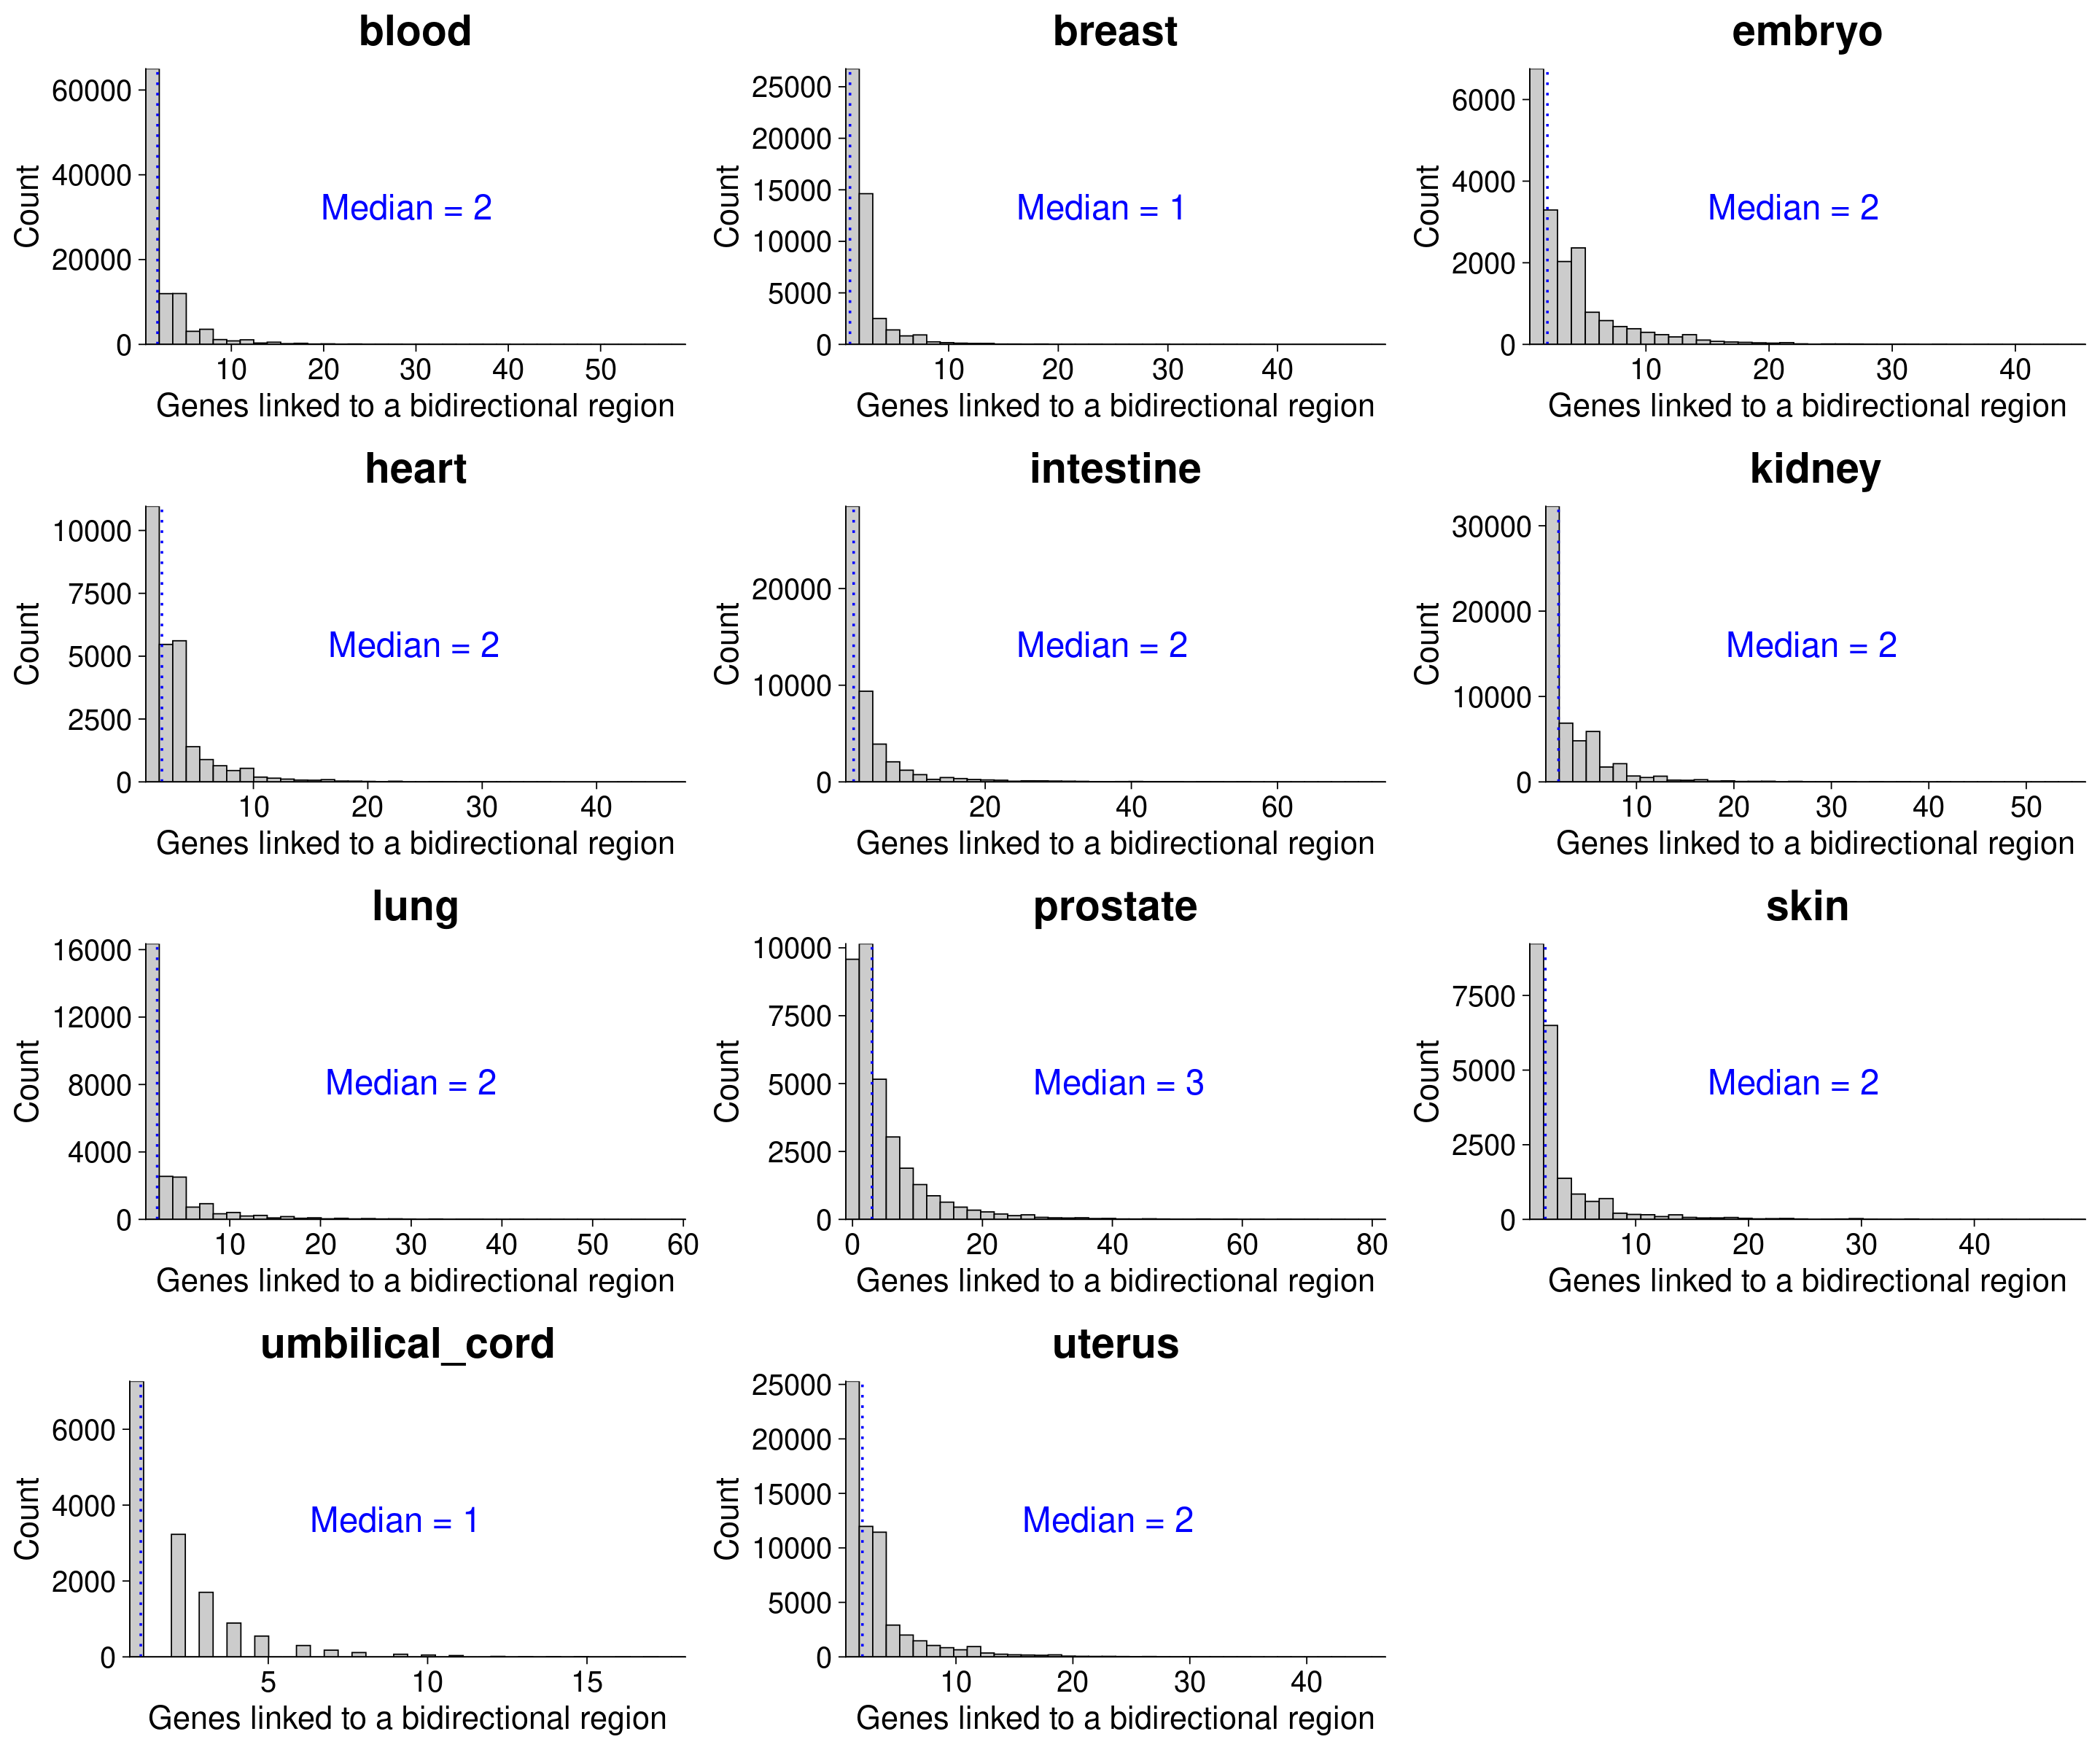

In [65]:
options(repr.plot.width=24, repr.plot.height=20)
num_genes_per_bidir_all_tissues <- cowplot::plot_grid(plotlist = gene_hist_plot_list,
                                                      ncol = 3)
num_genes_per_bidir_all_tissues


In [66]:
ggsave(num_genes_per_bidir_all_tissues, width = 24, height = 20,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_genes_per_bidir_all_tissues_plot.pdf',
      bg = "transparent")

ggsave(num_genes_per_bidir_all_tissues, width = 24, height = 20,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_genes_per_bidir_all_tissues_plot.png',
      bg = "transparent")

## Example genes

### MYC

In [67]:
myc_bidirs_tissue_list <- gene_bidirs_by_tissue(sig_pairs=sig_inter_nobs_dist_filtered, 
                                                metadata=metadata_celltype, 
                                                gene_id="MYC:")

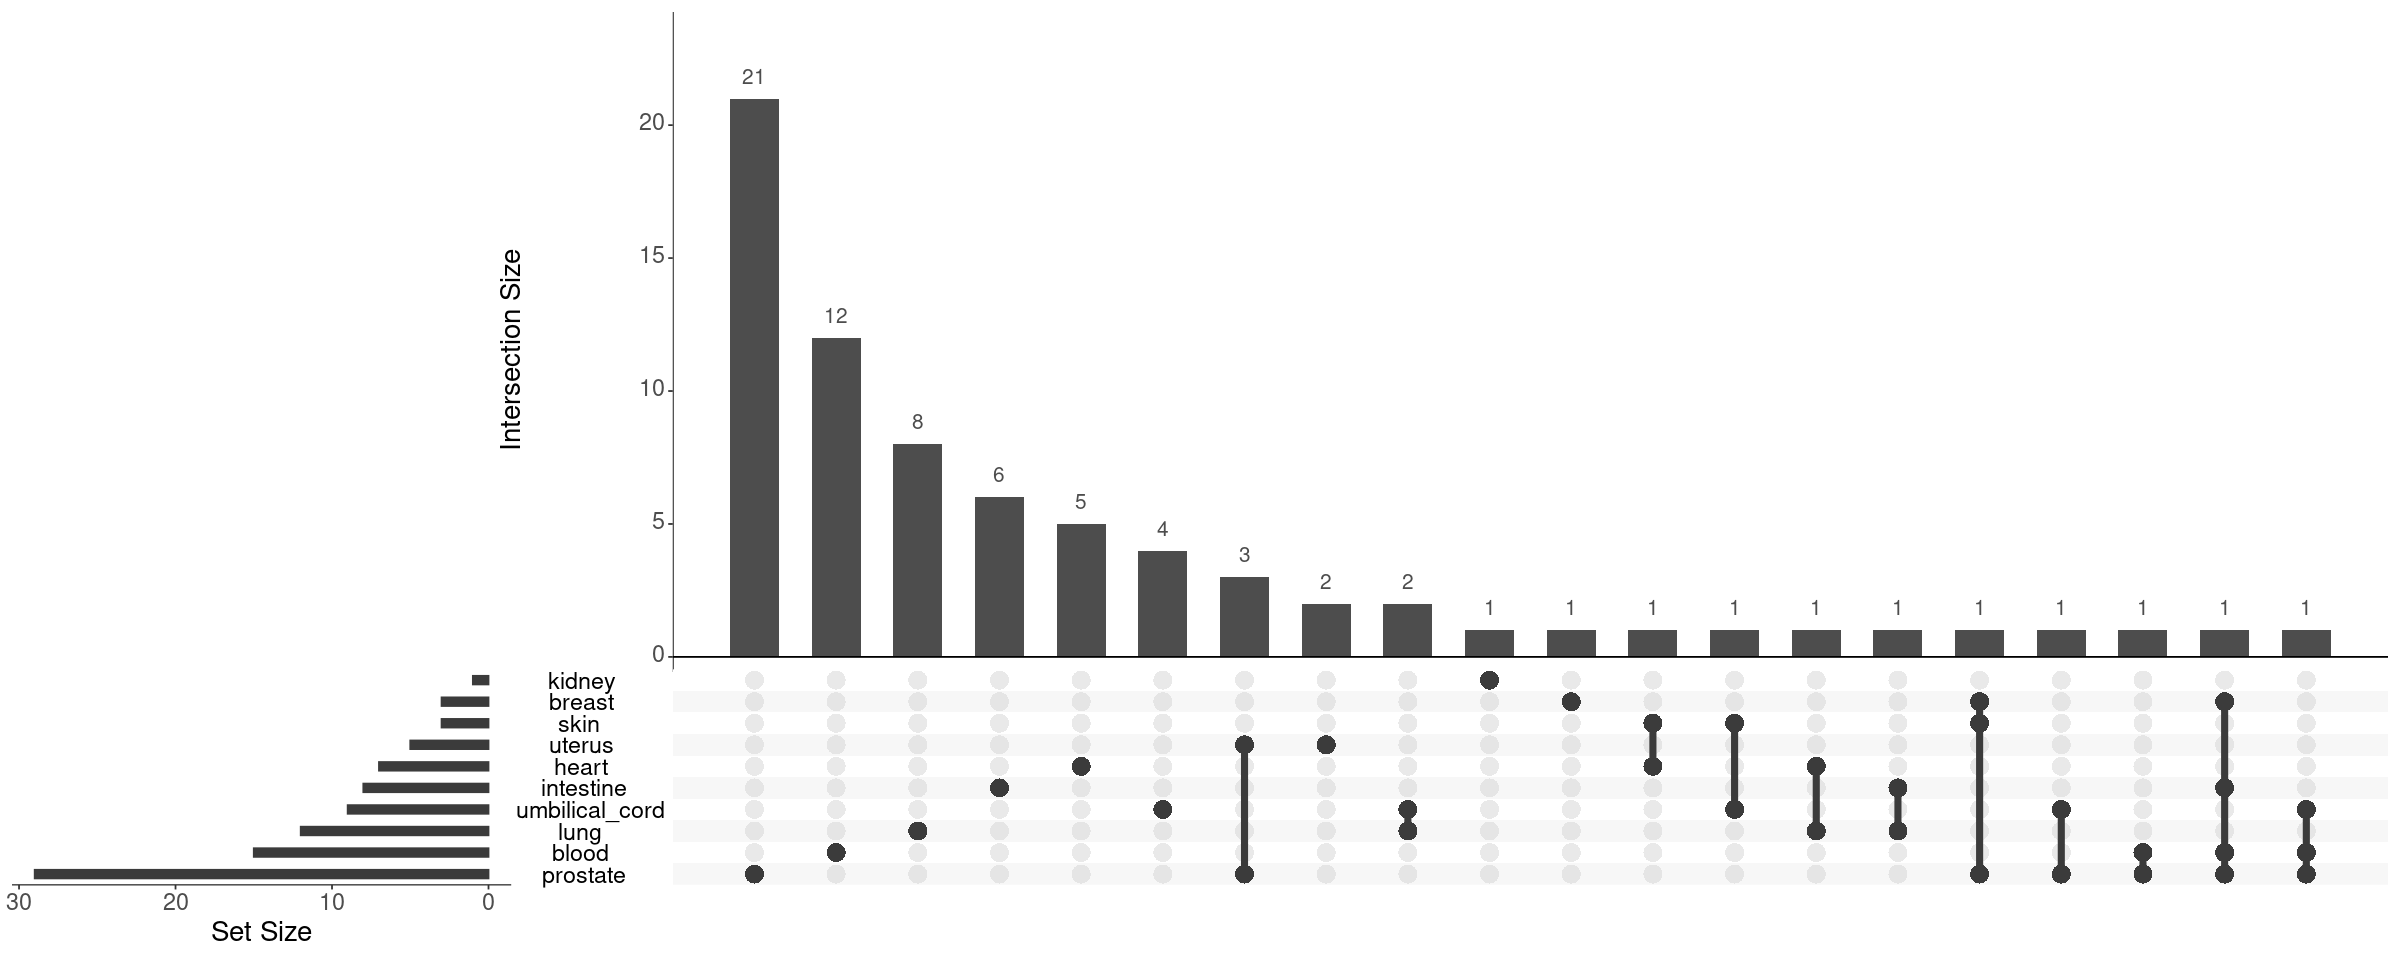

In [68]:
options(repr.plot.width=20, repr.plot.height=8)

myc_pair_summary_upset <- UpSetR::upset(fromList(myc_bidirs_tissue_list), 
                                        nsets = 100,
                                        nintersects = NA,
                                        #plot.title="Bla",  
                                        main.bar.color = "grey30",                                   
                                        order.by = "freq",
                                        point.size = 5,
                                        line.size = 2 ,
                                        text.scale = 2,
                                        set_size.show = FALSE) 

myc_pair_summary_upset

In [69]:
pdf(file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/myc_pair_summary_upset_plot.pdf", 
    width = 20,
    height = 8) 
myc_pair_summary_upset
dev.off()

png 
  2

### HCG18

In [70]:
hcg18_bidirs_tissue_list <- gene_bidirs_by_tissue(sig_pairs=sig_inter_nobs_dist_filtered, 
                                                metadata=metadata_celltype, 
                                                gene_id="HCG18:")

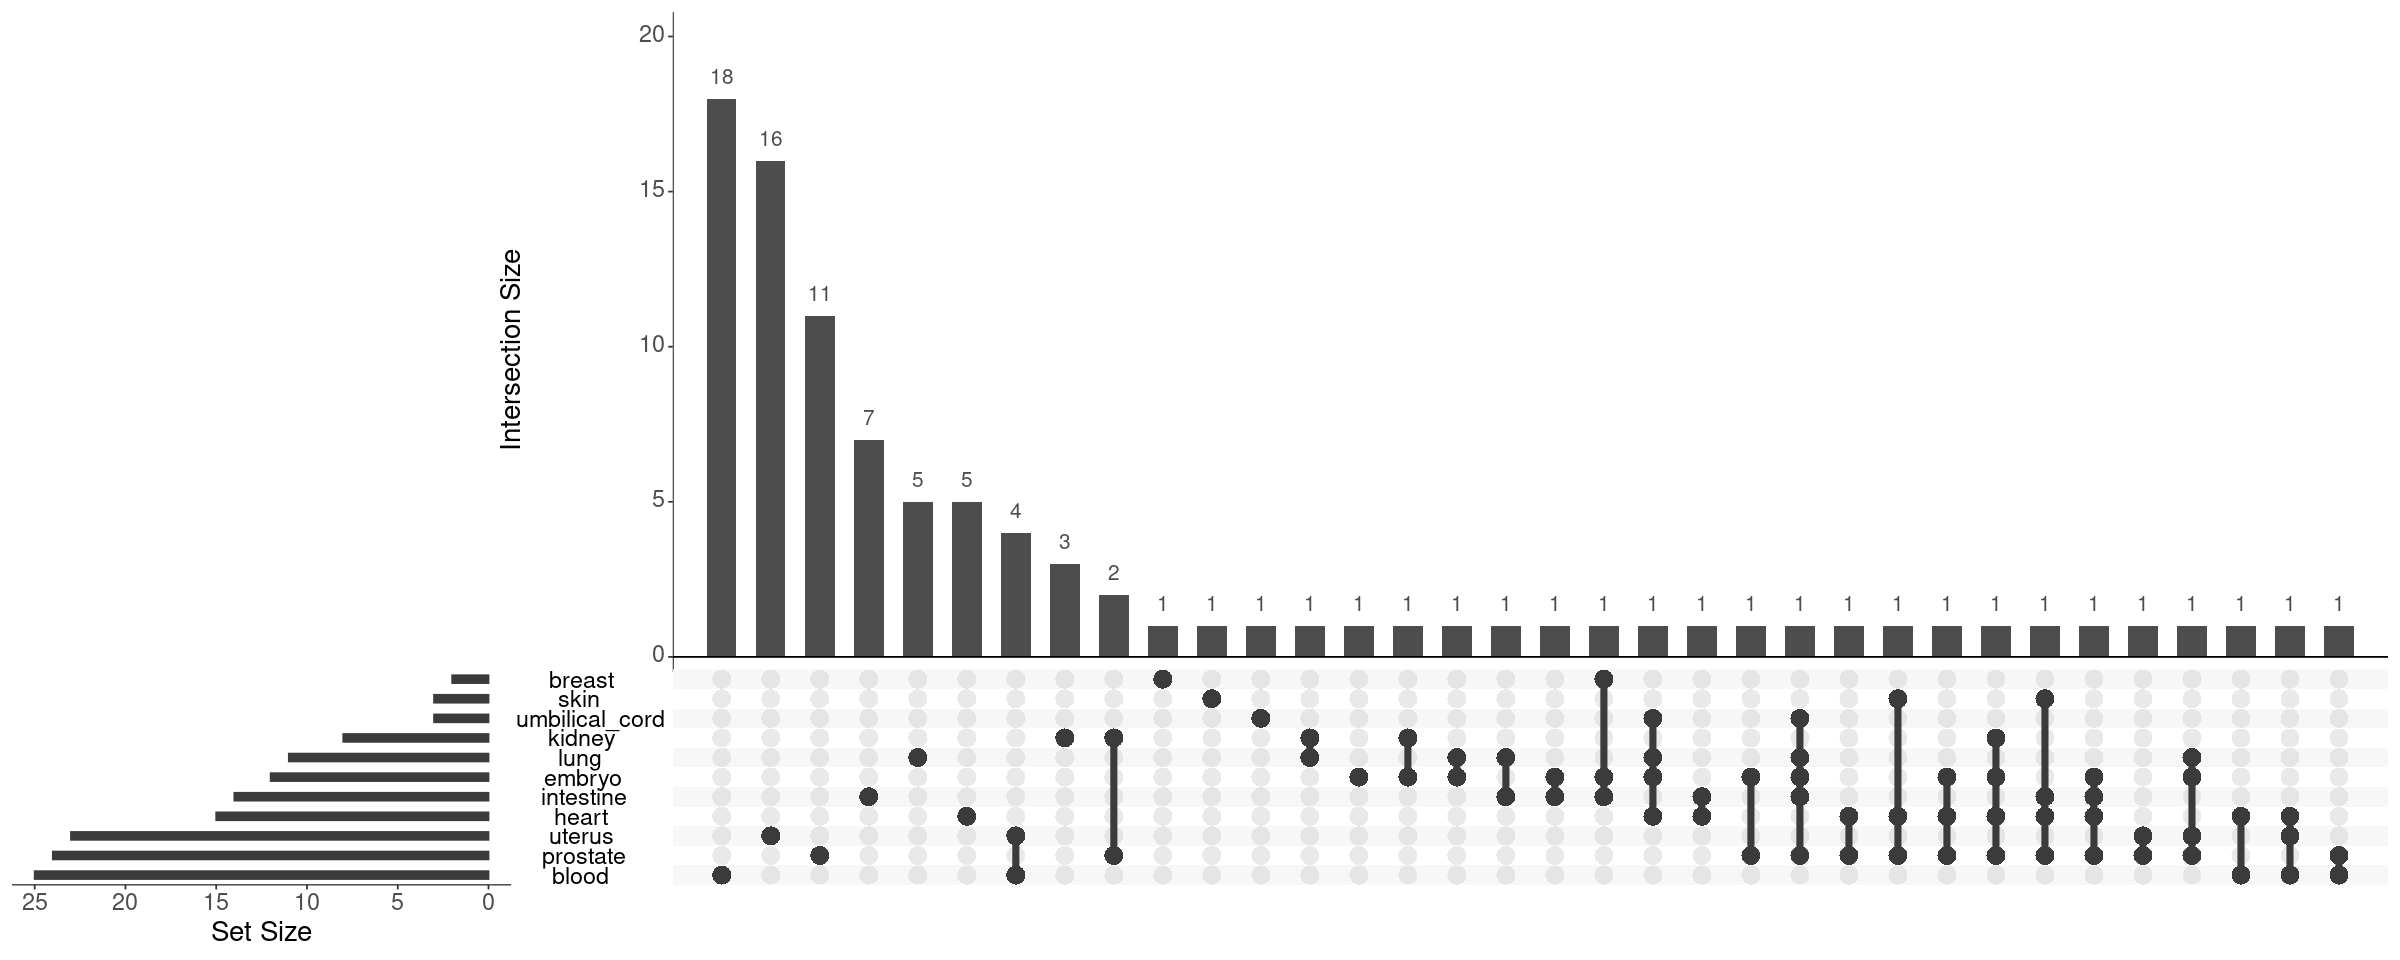

In [71]:
options(repr.plot.width=20, repr.plot.height=8)

hcg18_pair_summary_upset <- UpSetR::upset(fromList(hcg18_bidirs_tissue_list), 
                                        nsets = 100,
                                        nintersects = NA,
                                        main.bar.color = "grey30",                                   
                                        order.by = "freq",
                                        point.size = 5,
                                        line.size = 2 ,
                                        text.scale = 2,
                                        set_size.show = FALSE) 

hcg18_pair_summary_upset

In [72]:
pdf(file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/hcg18_pair_summary_upset_plot.pdf", 
    width = 20,
    height = 8) 
hcg18_pair_summary_upset
dev.off()

png 
  2

### SUMO2

In [73]:
sumo2_bidirs_tissue_list <- gene_bidirs_by_tissue(sig_pairs=sig_inter_nobs_dist_filtered, 
                                                metadata=metadata_celltype, 
                                                gene_id="SUMO2:")

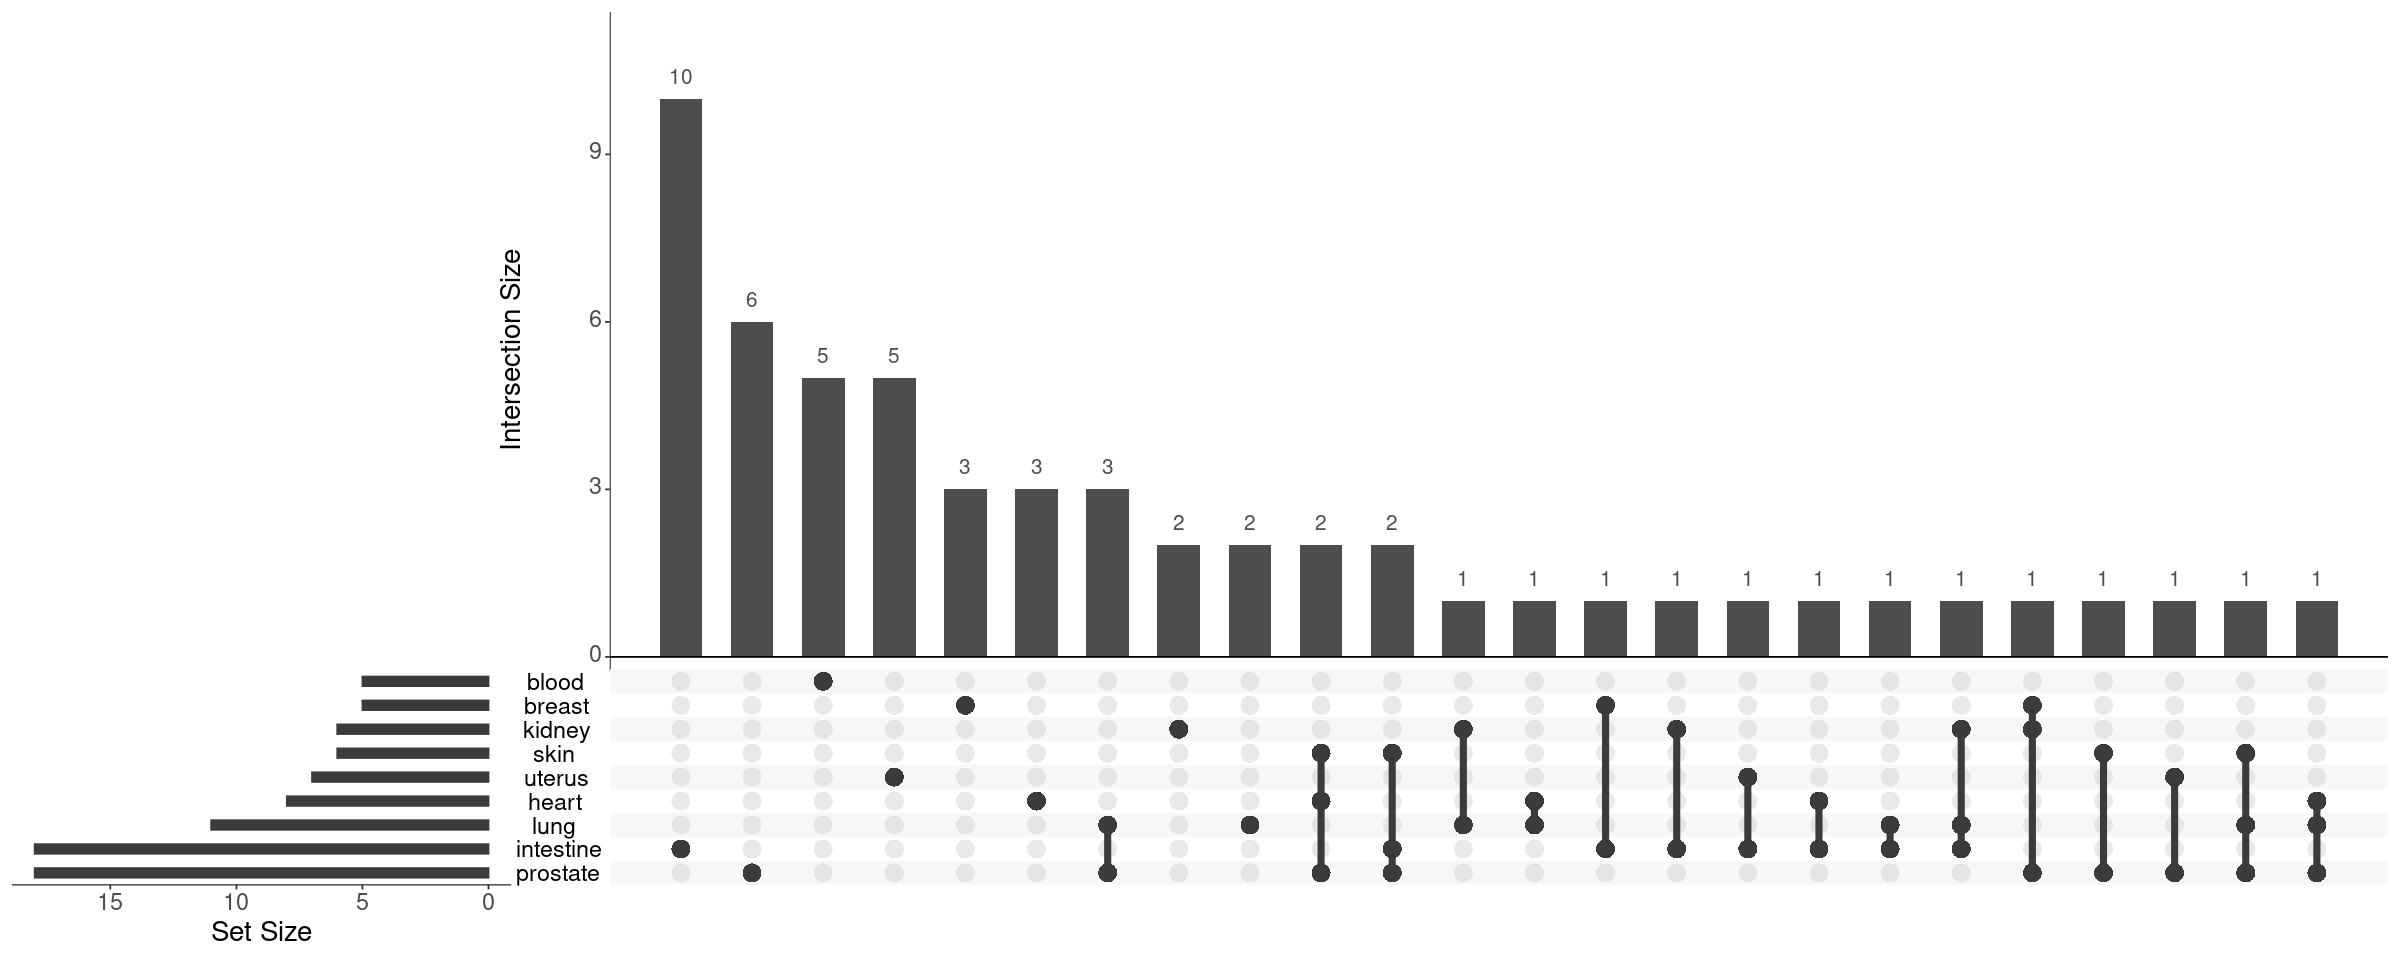

In [74]:
options(repr.plot.width=20, repr.plot.height=8)

sumo2_pair_summary_upset <- UpSetR::upset(fromList(sumo2_bidirs_tissue_list), 
                                        nsets = 100,
                                        nintersects = NA,
                                        #plot.title="Bla",  
                                        main.bar.color = "grey30",                                   
                                        order.by = "freq",
                                        point.size = 5,
                                        line.size = 2 ,
                                        text.scale = 2,
                                        set_size.show = FALSE) 

sumo2_pair_summary_upset

In [75]:
pdf(file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/sumo2_pair_summary_upset_plot.pdf", 
    width = 20,
    height = 8) 
sumo2_pair_summary_upset
dev.off()

png 
  2

### GAPDH

In [76]:
gapdh_bidirs_tissue_list <- gene_bidirs_by_tissue(sig_pairs=sig_inter_nobs_dist_filtered, 
                                                metadata=metadata_celltype, 
                                                gene_id="GAPDH:")

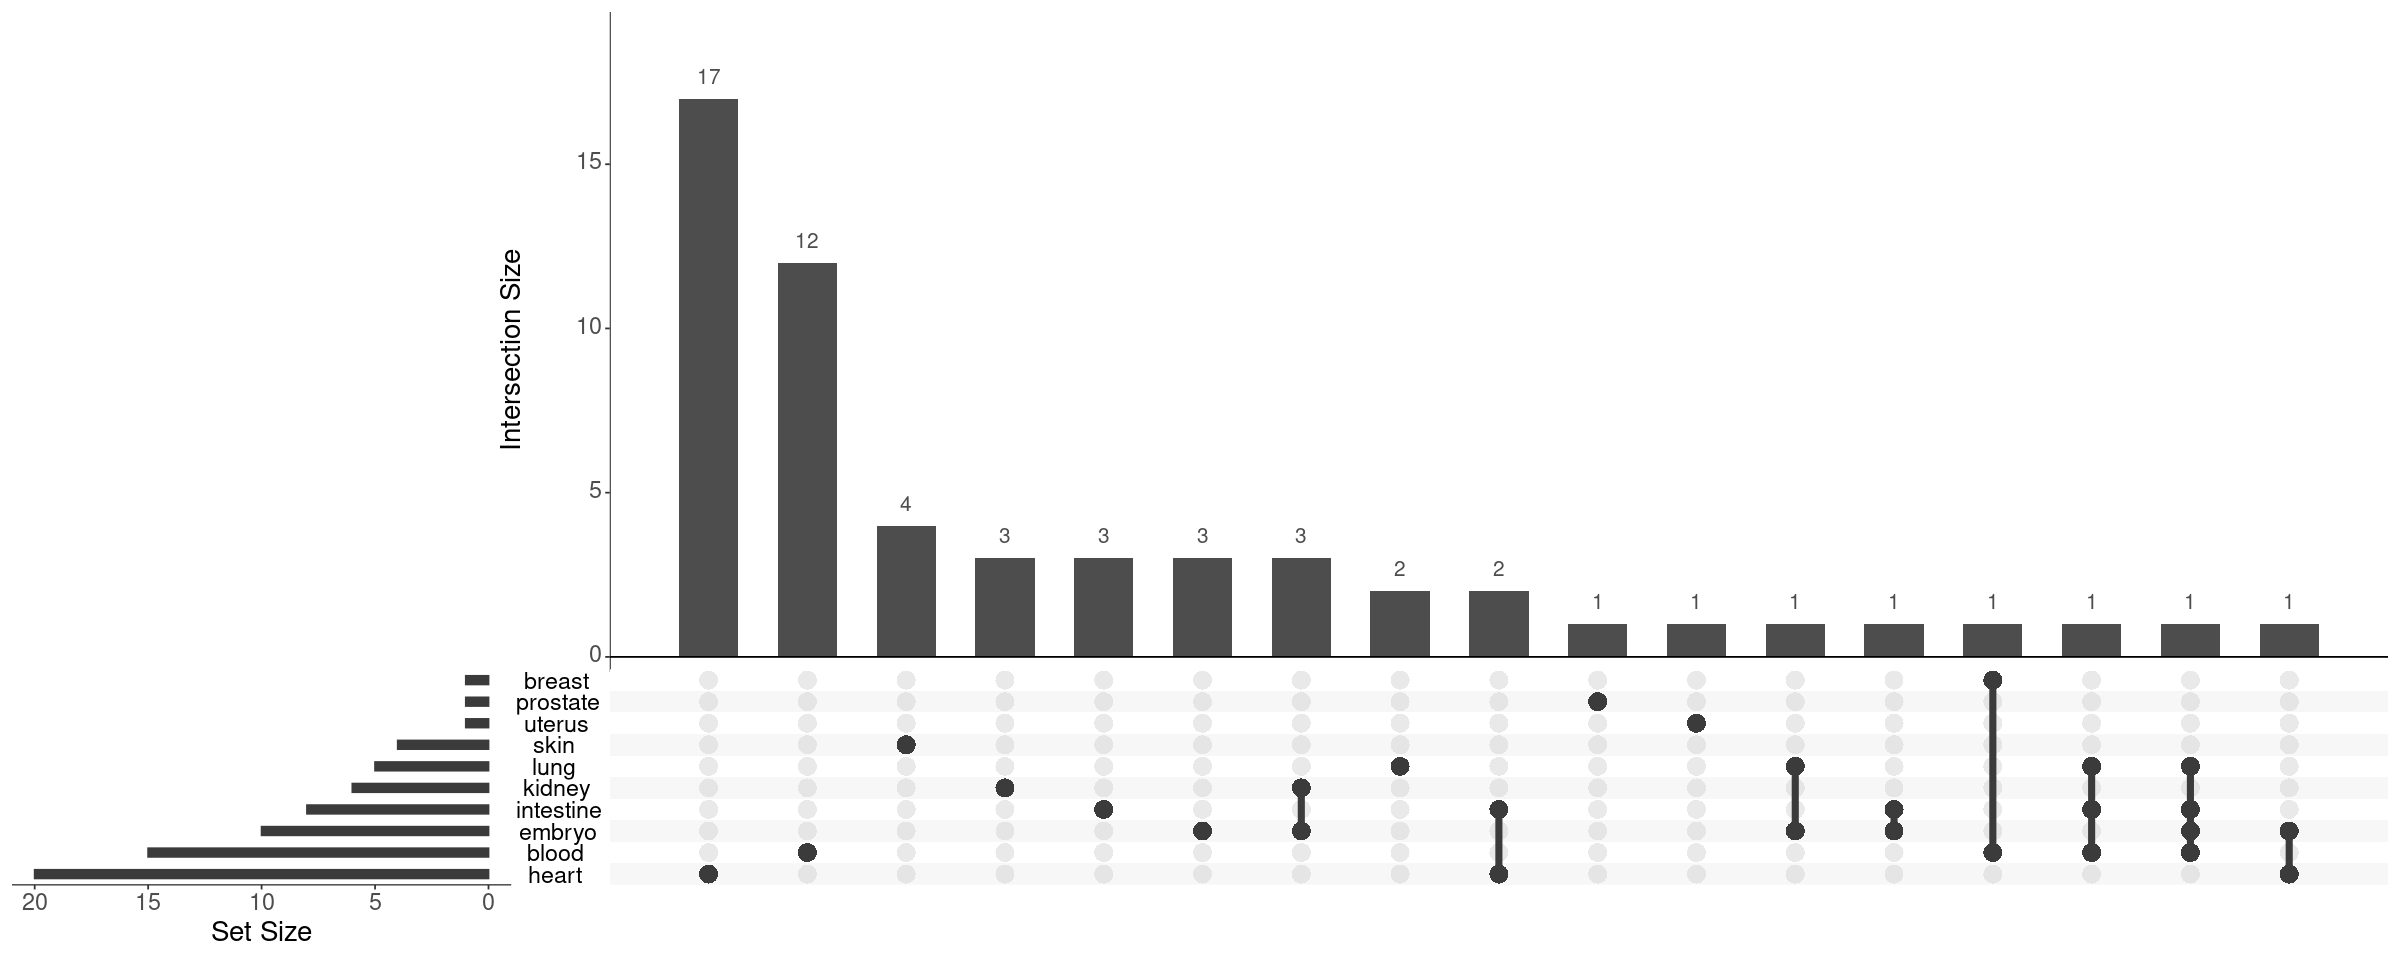

In [77]:
options(repr.plot.width=20, repr.plot.height=8)

gapdh_pair_summary_upset <- UpSetR::upset(fromList(gapdh_bidirs_tissue_list), 
                                        nsets = 100,
                                        nintersects = NA,
                                        #plot.title="Bla",  
                                        main.bar.color = "grey30",                                   
                                        order.by = "freq",
                                        point.size = 5,
                                        line.size = 2 ,
                                        text.scale = 2,
                                        set_size.show = FALSE) 

gapdh_pair_summary_upset

In [78]:
pdf(file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/gapdh_pair_summary_upset_plot.pdf", 
    width = 20,
    height = 8) 
gapdh_pair_summary_upset
dev.off()

png 
  2

### RUNX1

In [79]:
runx1_bidirs_tissue_list <- gene_bidirs_by_tissue(sig_pairs=sig_inter_nobs_dist_filtered, 
                                                metadata=metadata_celltype, 
                                                gene_id="RUNX1:")

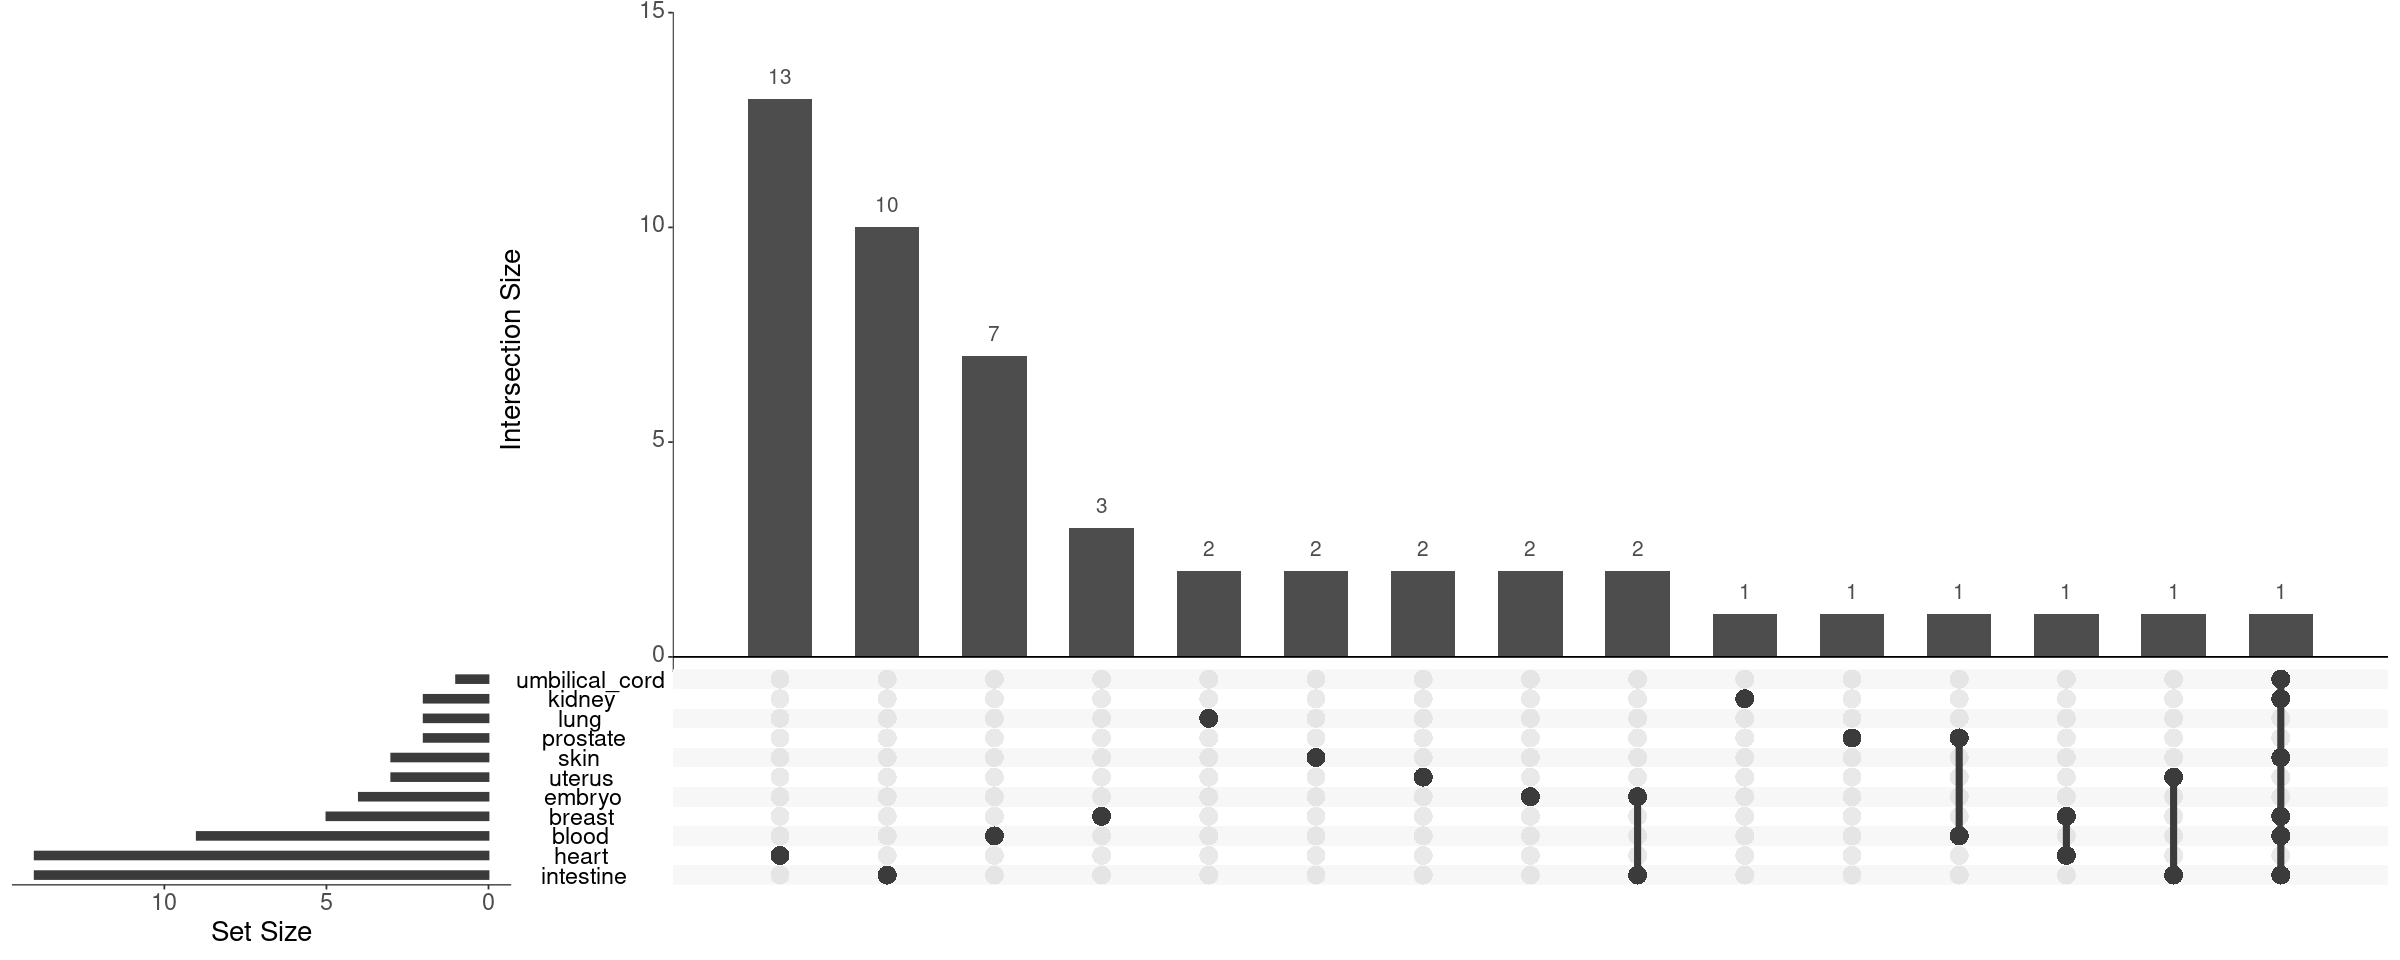

In [80]:
options(repr.plot.width=20, repr.plot.height=8)

runx1_pair_summary_upset <- UpSetR::upset(fromList(runx1_bidirs_tissue_list), 
                                        nsets = 100,
                                        nintersects = NA,  
                                        main.bar.color = "grey30",                                   
                                        order.by = "freq",
                                        point.size = 5,
                                        line.size = 2 ,
                                        text.scale = 2,
                                        set_size.show = FALSE) 

runx1_pair_summary_upset

In [81]:
pdf(file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/runx1_pair_summary_upset_plot.pdf", 
    width = 20,
    height = 8) 
runx1_pair_summary_upset
dev.off()

png 
  2

# Session Information

In [82]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] UpSetR_1.4.0      cowplot_1.1.1     dplyr_1.0.10      ggplot2_3.3.6    
[5] data.table_1.14.2

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.8.3      plyr_1.8.7        pillar_1.8.1      compiler_3.6.0   
 [5] R.methodsS3_1.8.2 R.utils_2.12.0    base64enc_0.1-3   tools_3.6.0      
 [9] digest_0.6.29     uuid_1.1-0      